In [1]:
import numpy as np
from utils import plot_signals

# PLL
 1. Choose noise bandwidth $B_n$ for loop filter - between 1% and 5% of sample rate should be fine. The higher it is the more frequency offset PLL can handle, but it loses track more easily.
 2. Choose damping factor - typically between 0.5 and 2, $\frac{1}{\sqrt 2}$ (0.707) is commonly selected. The higher it is the less fluctuation there is while obtaining lock, but it takes longer.

$$K_p = \frac{1}{K_D K_0} \frac{4 \zeta}{\zeta + \frac{1}{4 \zeta}} \frac{B_n}{F_s}$$

$$K_i = \frac{1}{K_D K_0} \frac{4}{(\zeta + \frac{1}{4 \zeta})^2} (\frac{B_n}{F_s})^2$$

$K_D$ is phase error detector gain and $K_0$ is NCO gain (typically set to 1).

Source: [WirelessPi on PLLs](https://wirelesspi.com/phase-locked-loop-pll-in-a-software-defined-radio-sdr/)

In [2]:
def calc_loop_params(damping_factor, noise_bandwidth, sample_rate, ped_gain=0.5, nco_gain=1):
    k_p = (4 * damping_factor * noise_bandwidth) / (ped_gain * nco_gain * (damping_factor + 1 / (4 * damping_factor)) * sample_rate)
    k_i = (4 * noise_bandwidth ** 2) / (ped_gain * nco_gain * ((damping_factor + 1 / (4 * damping_factor)) * sample_rate) ** 2)
    return k_p, k_i

In [3]:
f_0 = 19000
sample_rate = 250_000
damping_factor = 1 / np.sqrt(2)
noise_bandwidth = 0.05 * sample_rate
k_p, k_i = calc_loop_params(damping_factor, noise_bandwidth, sample_rate)
k_p, k_i  # just like on WirelessPi

(0.26666666666666666, 0.01777777777777778)

In [4]:
def pll(input_signal, sample_rate, f_0, k_p, k_i, nco_gain):
    phases, errors = [], []
    integrator_acc, phase = 0, 0
    
    for i, sample in enumerate(input_signal):
        # cos here means phases will be for use in sin function
        error = np.cos(2 * np.pi * f_0 * i / sample_rate + phase) * sample
        
        integrator_acc += (k_i * error)
        phase += (nco_gain * (integrator_acc + k_p * error))

        phases.append(phase)
        errors.append(error)
        
    return phases, errors

### PLL with frequency and phase offset
Interesting, with these parameters it can handle really high frequency offset (10kHz vs $f_0$ of 19kHz).

In [5]:
t_s = np.arange(0, 1, 1 / sample_rate)
frequency_offset = 10000
phase_offset = 0.8 * np.pi
signal = np.sin(2 * np.pi * (f_0 + frequency_offset) * t_s + phase_offset)
phases, errors = pll(signal, sample_rate, f_0, k_p, k_i, 1)

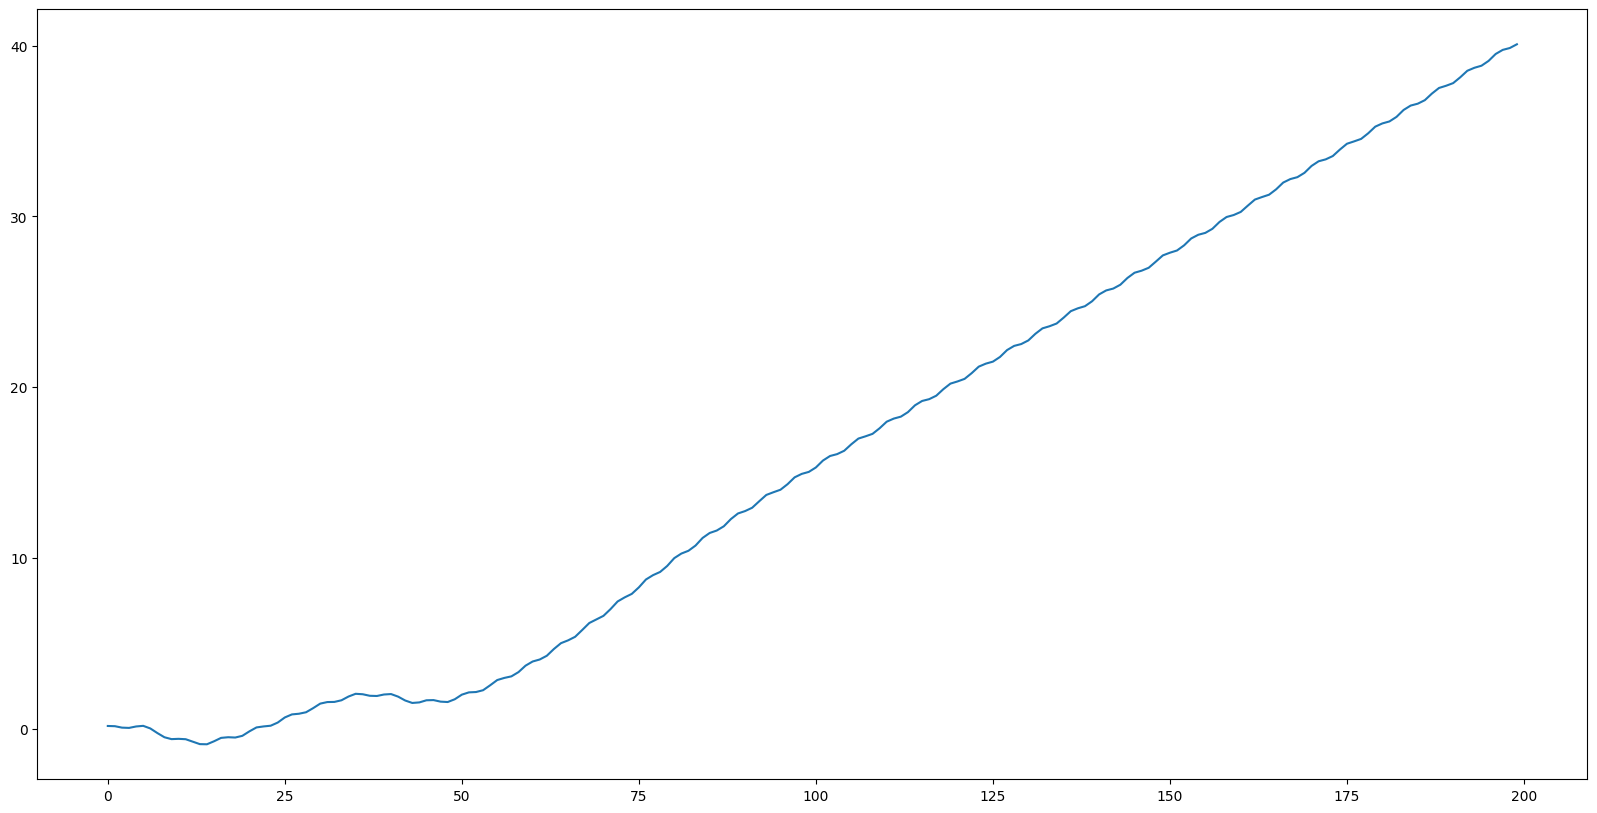

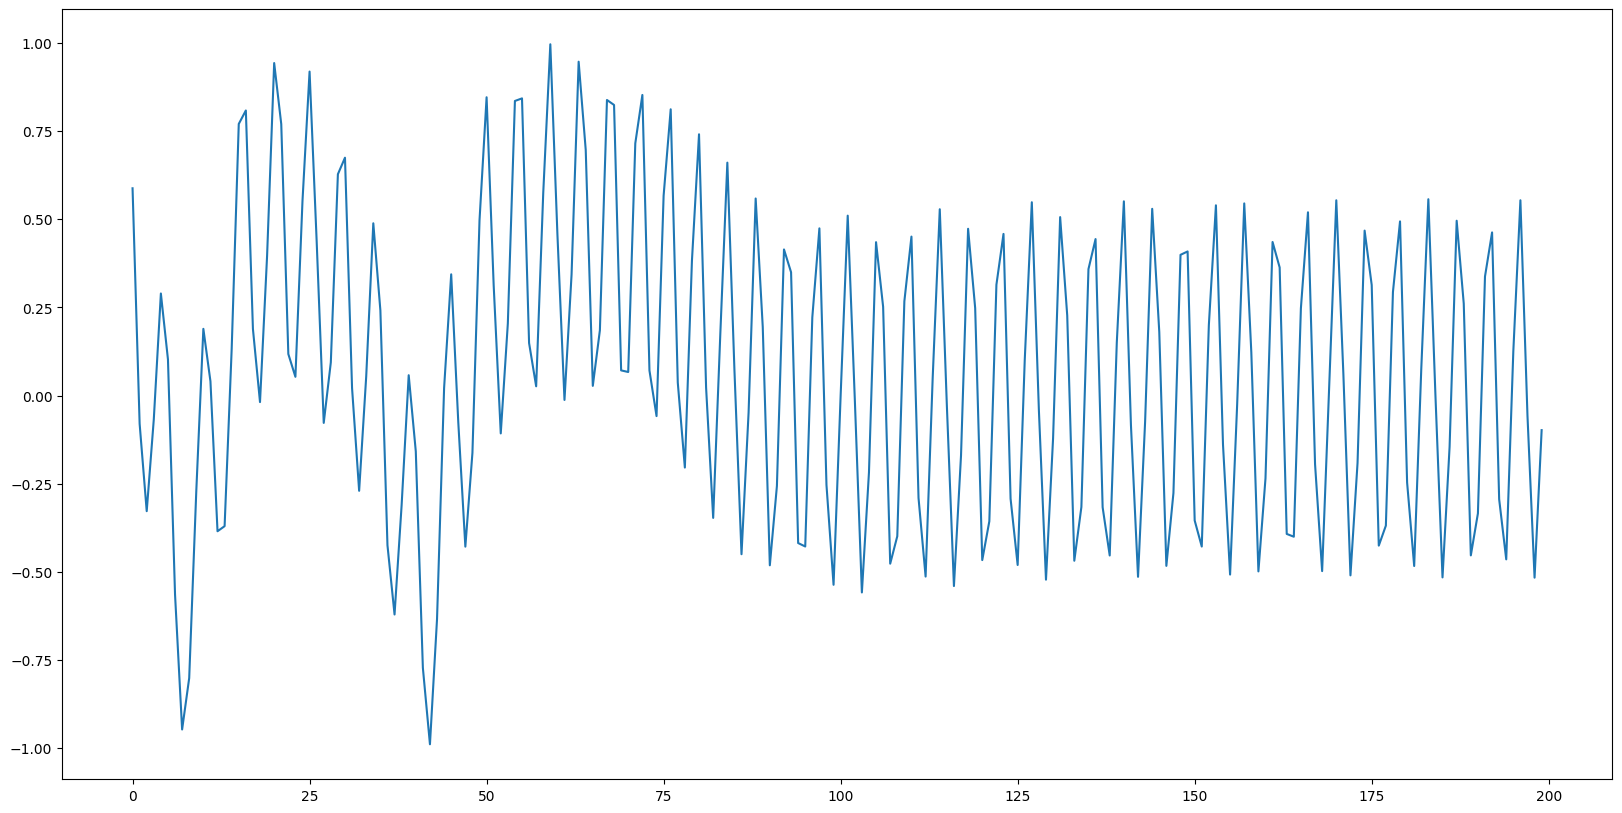

In [6]:
start, width = 0, 200
plot_signals([phases], start=start, width=width, normalize=False)
plot_signals([errors], start=start, width=width, normalize=False)

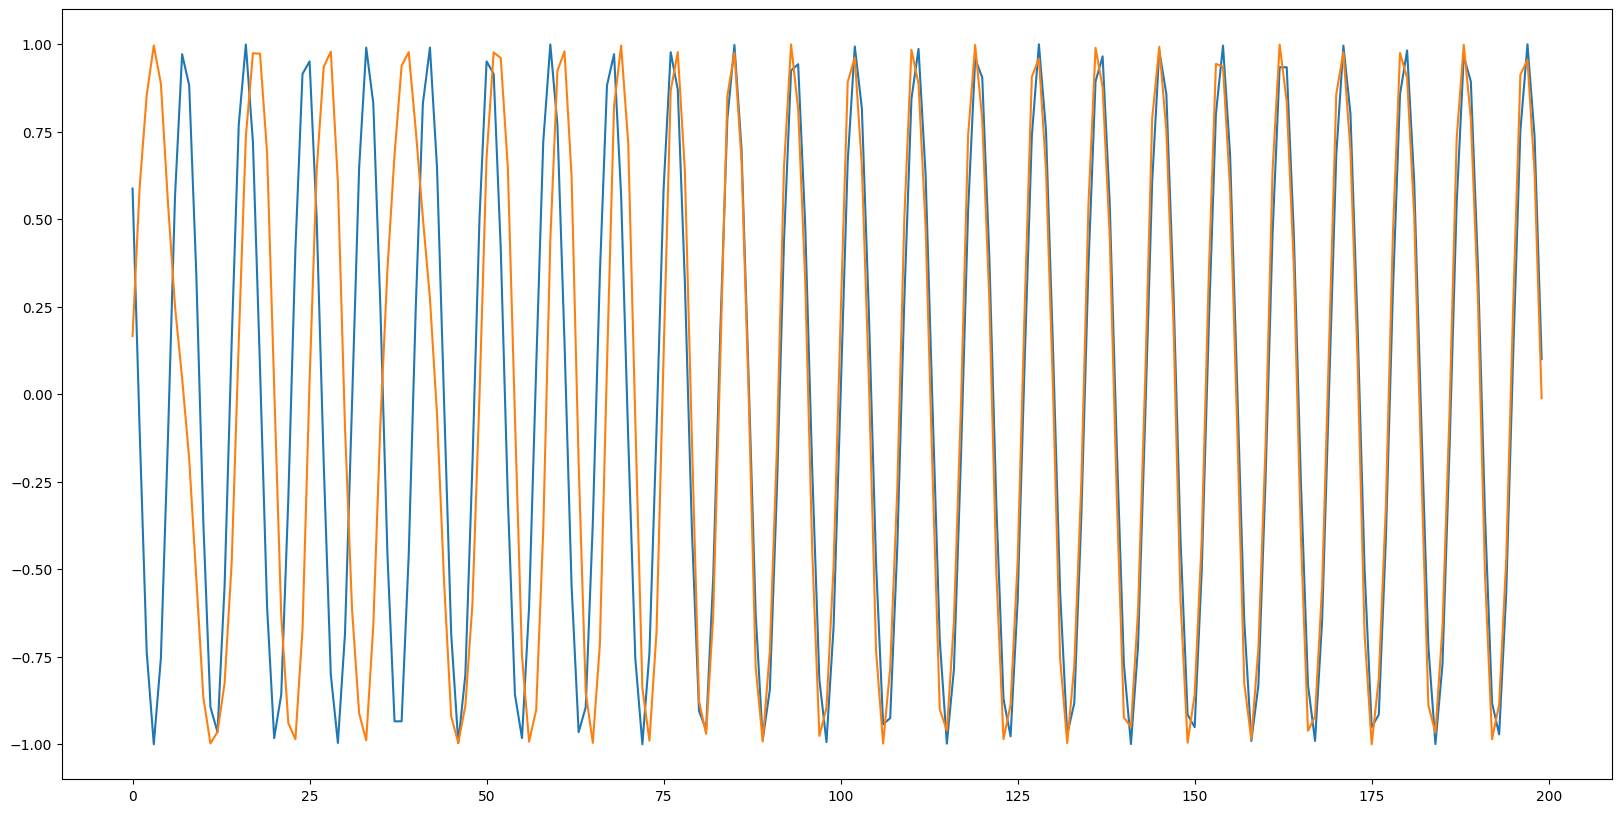

In [7]:
plot_signals([signal, np.sin(2 * np.pi * f_0 * t_s + phases)], start=start, width=width)

#### PLL frequency pull-in range
[1] (C.41) says that pull-in range for the phase-locked loop can be approximated by $2 \pi \sqrt 2 \zeta B_n$ (that's the largest frequency offset).

In [8]:
print(f'Max frequency offset is {2 * np.pi * np.sqrt(2) * damping_factor * noise_bandwidth}Hz')

Max frequency offset is 78539.81633974482Hz


79kHz looks like a lot, especially given that my base frequency is 19kHz! But signal is also heavily oversampled so this estimate is much higher. We can plot normalized approximate derivative of the phase estimate and see if it converges to given frequency offset.

In [9]:
def test_frequency_offset(frequency_offset, start, width):
    signal = np.sin(2 * np.pi * (f_0 + frequency_offset) * t_s + phase_offset)
    phases, errors = pll(signal, sample_rate, f_0, k_p, k_i, 1)
    phases = np.array(phases)

    phase_derivative = (phases[1:] - phases[:-1]) * sample_rate / (2 * np.pi)
    plot_signals([phase_derivative], start=start, width=width, normalize=False)

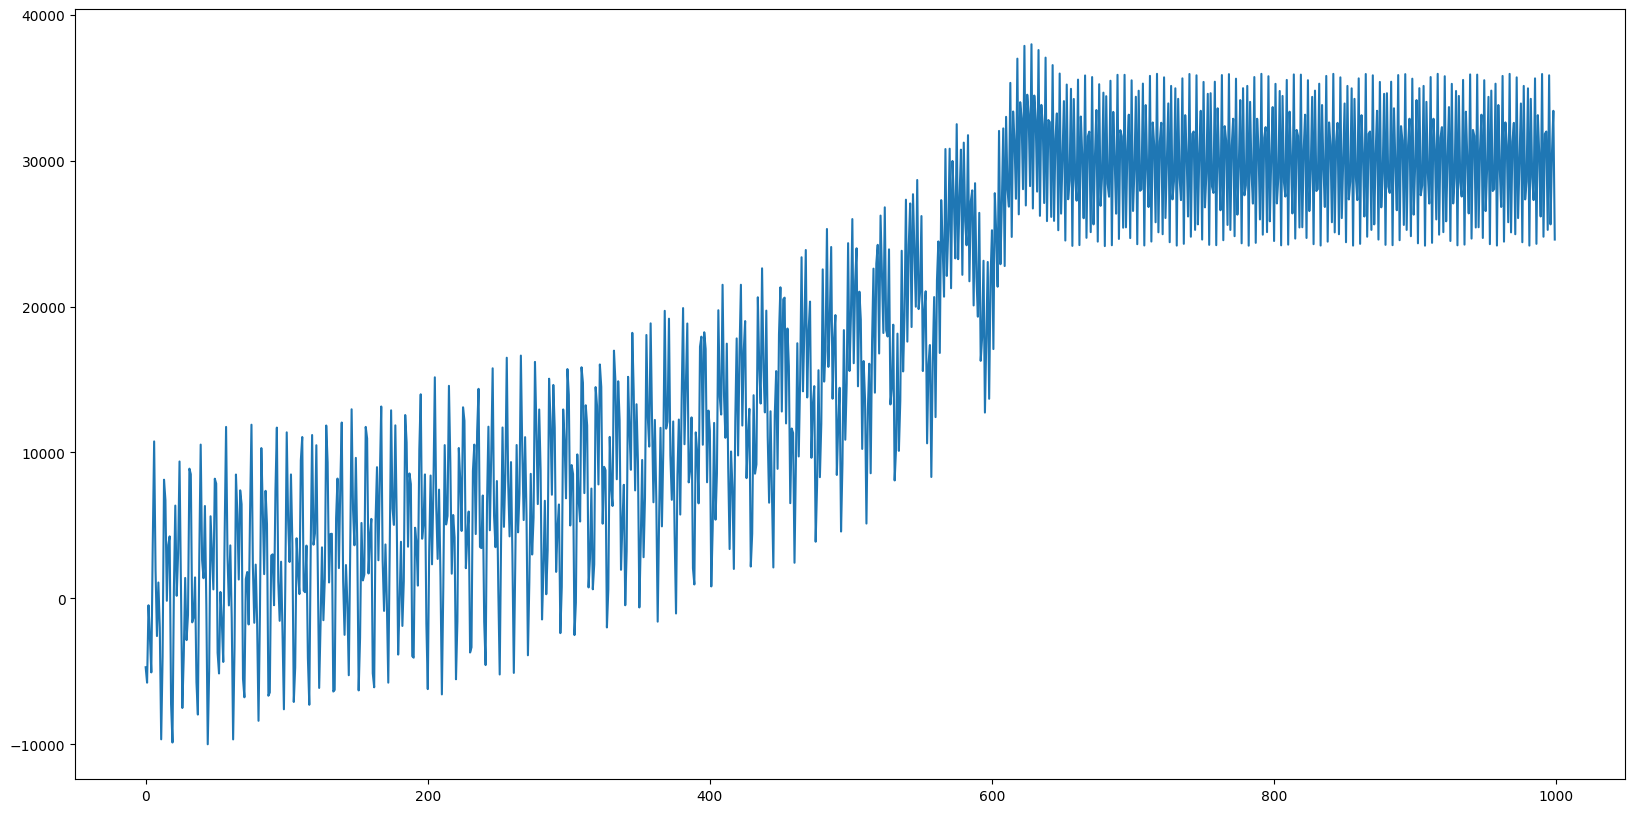

In [10]:
test_frequency_offset(30000, 0, 1000)

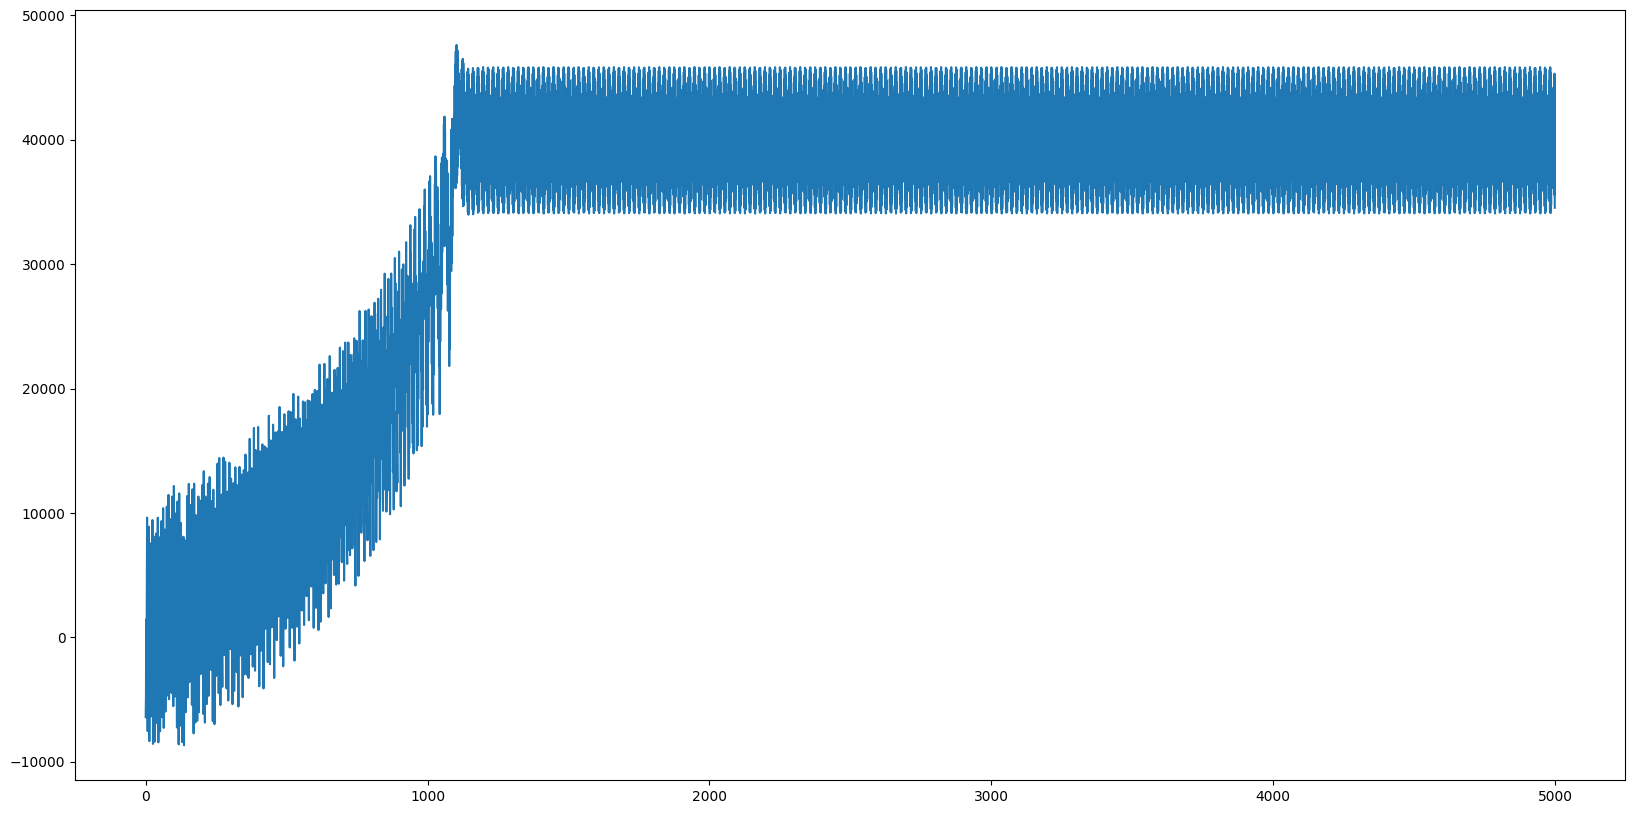

In [11]:
test_frequency_offset(40000, 0, 5000)

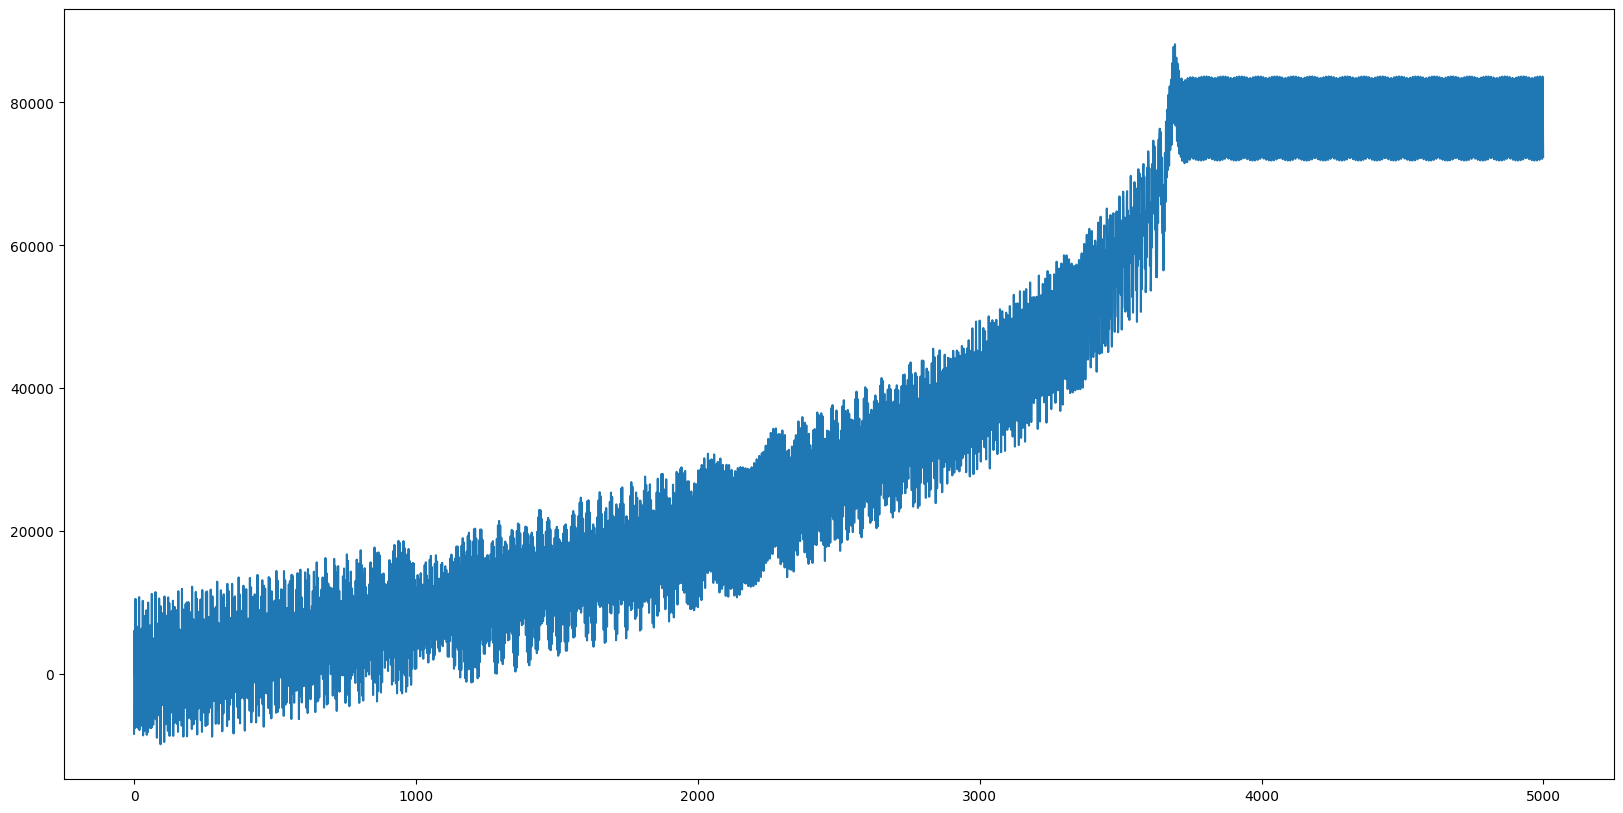

In [12]:
test_frequency_offset(78000, 0, 5000)

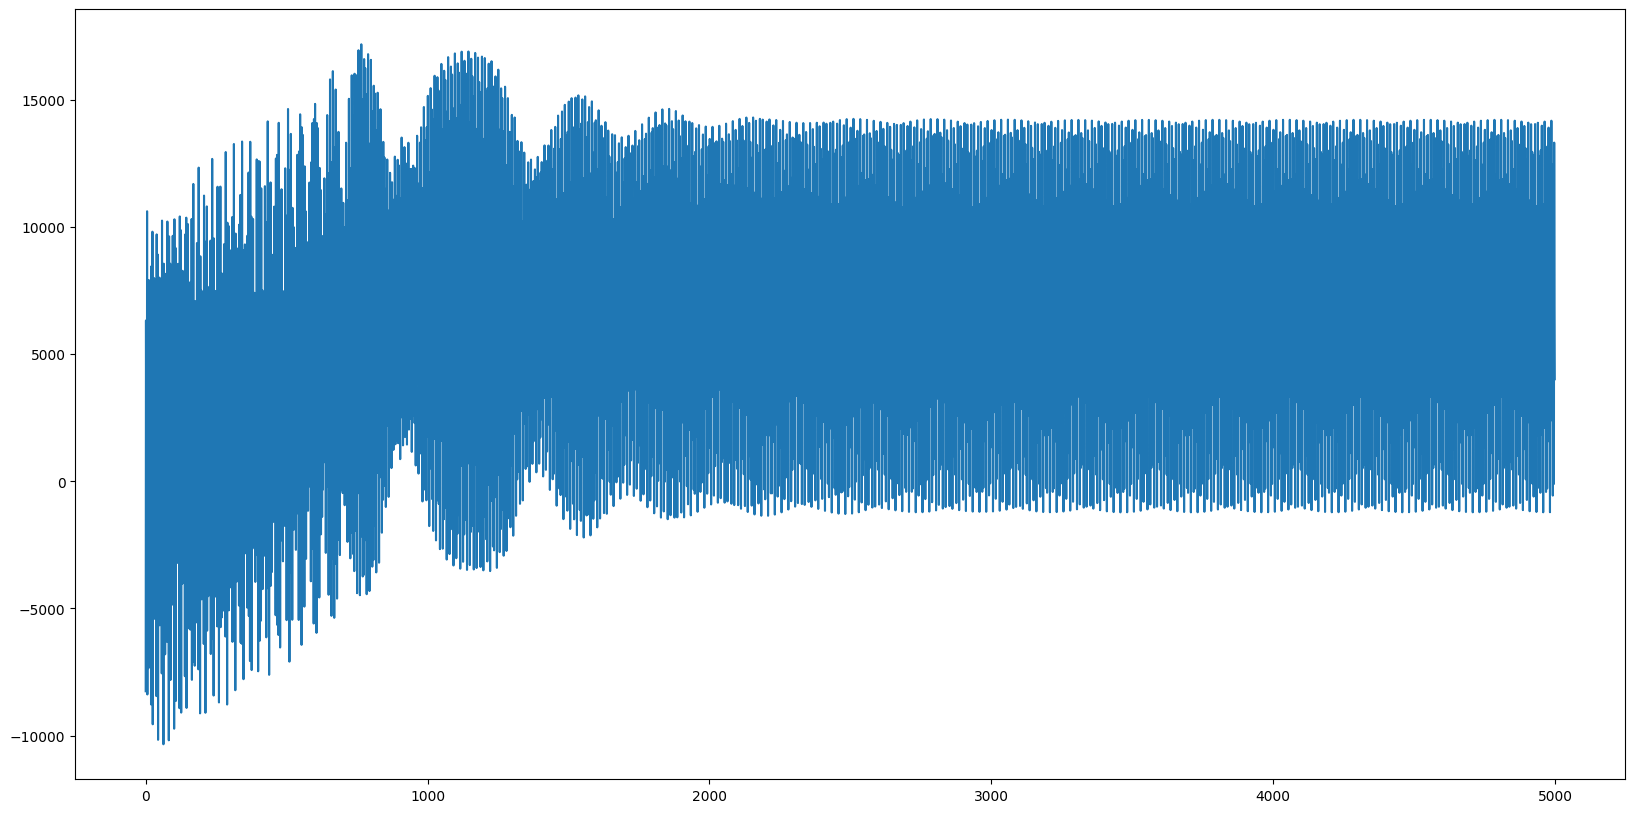

In [13]:
test_frequency_offset(80000, 0, 5000)

That looks like expected...

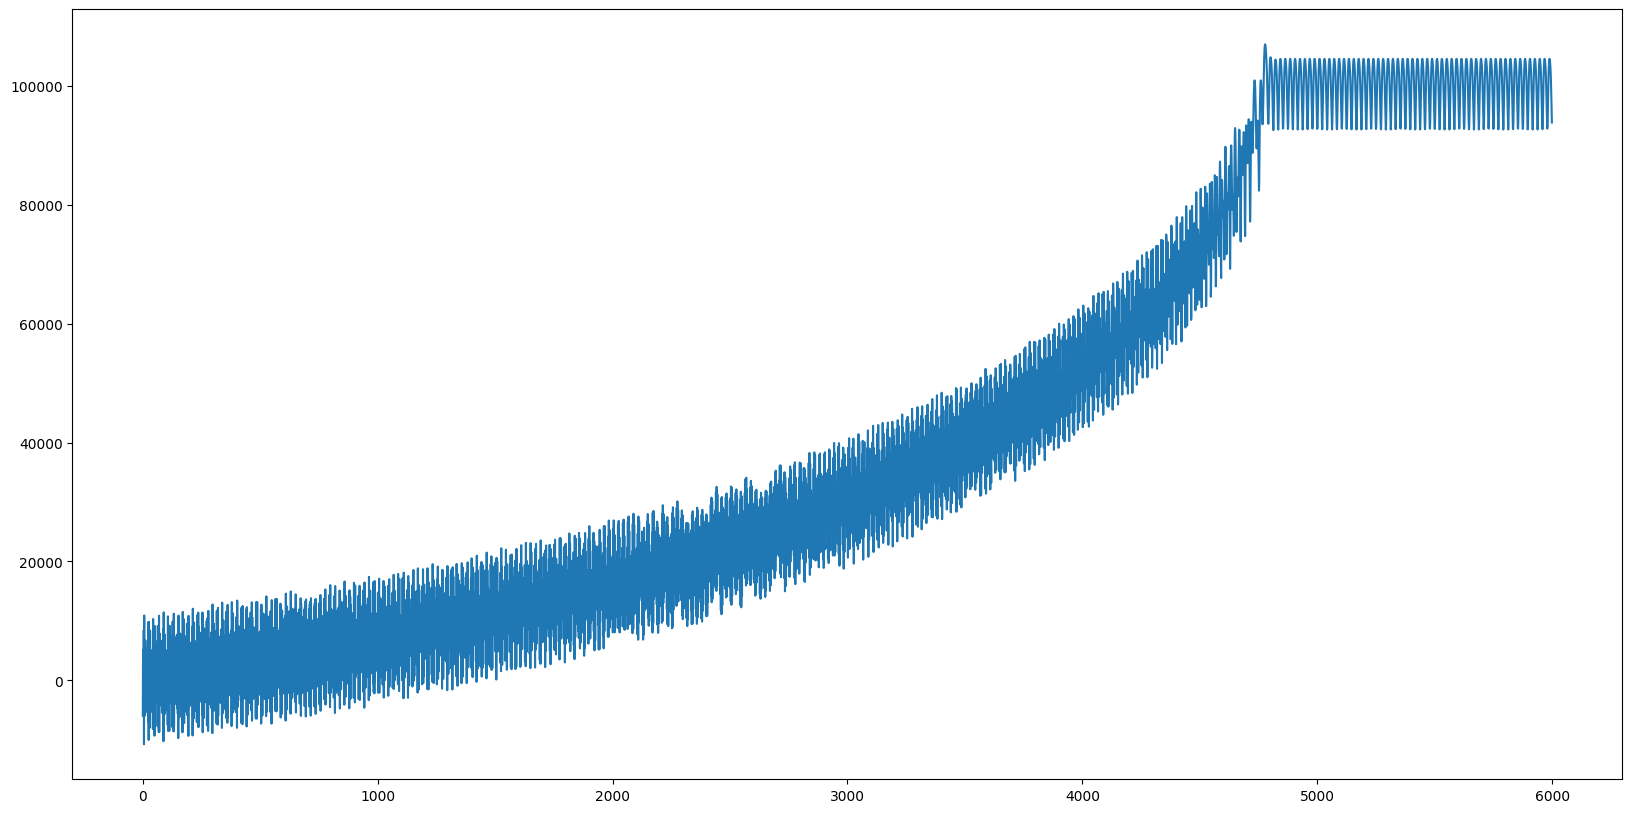

In [14]:
test_frequency_offset(100000, 0, 6000)

But WTF. Way above pull-in range but phase estimates seem to still compensate the frequency offset. 100kHz + 19kHz should not be enough for some weird frequency aliasing effect to occur with sampling rate of 250kHz.

For now let it remain a mystery.

# Costas loop
From what I understand PLL above won't work for e.g. BPSK modulated signal. We need additional trickery to get phase error between our estimate and carrier phase.

Sources:
  1. R.E. Best *Digital Communications – A Discrete-Time Approach* - appendix C (C.59) gives loop filter coefficient formulas with full derivation, awesome
  2. R.E. Best, N.V. Kuznetsov et al. *Tutorial on dynamic analysis of the Costas loop* - equation (56) shows that BPSK Costas loop transfer function is identical to PLL transfer function from [1], so (I guess?) exact same formulas for loop filter coefficients as for a PLL can be applied.

In [15]:
# WTF is this shit after all??? seems useless for my implementation
def calc_costas_params(damping_factor, noise_bandwidth, sample_rate, symbol_period, ped_gain=1, nco_gain=1):
    # loop natural radian frequency
    # source: https://scholarsmine.mst.edu/cgi/viewcontent.cgi?article=8047&context=masters_theses  (2-22)
    w_n = 4 * damping_factor * (2 * np.pi * 2 * noise_bandwidth) / (1 + 4 * damping_factor ** 2)

    arg = damping_factor * w_n * symbol_period
    k_p = 2 / ped_gain * np.exp(-arg) * np.sinh(arg)

    # loop damped radian frequency - from GNURadio docstring
    w_d = w_n * np.sqrt(1 - damping_factor ** 2)
    # formula for under-damped loop (damping factor < 1)
    k_i = 2 / ped_gain * (1 - np.exp(-arg) * (np.sinh(arg) + np.cos(w_d * symbol_period)))
    
    return k_p, k_i

def calc_costas_params2(damping_factor, noise_bandwidth, sample_rate, symbol_period, ped_gain=0.5, nco_gain=1):
    # loop natural radian frequency
    # source: https://scholarsmine.mst.edu/cgi/viewcontent.cgi?article=8047&context=masters_theses  (2-22)
    w_n = 4 * damping_factor * noise_bandwidth / (1 + 4 * damping_factor ** 2) * symbol_period

    # source: tutorial on Costas paper (58), (15)
    tau_1 = nco_gain * ped_gain / w_n ** 2
    tau_2 = 2 * damping_factor / w_n
    k_p = tau_2 / tau_1
    k_i = 1 / tau_1

    return k_p, k_i

Above methods did not work at all, not sure if I implemented them properly tho. `calc_costas_params2` is for analog loop anyway so it won't work. GNURadio guys, I have no idea how they came up with all these `sinh` and other stuff.

But from [2] it seems that you can use the same coefficients as for analogous PLL so let's do that.

In [16]:
f_rds = 57000
rds_sample_rate = 171_000

# 1187.5 symbols per second in RDS
samples_per_symbol = rds_sample_rate // 1187.5

c_k_p, c_k_i = calc_loop_params(1 / np.sqrt(2), 0.05 * rds_sample_rate, rds_sample_rate, ped_gain=0.5, nco_gain=1)
print(f'Proportional gain K_p is {c_k_p} and integrator gain K_i is {c_k_i}')

Proportional gain K_p is 0.26666666666666666 and integrator gain K_i is 0.017777777777777785


In [17]:
def costas_loop(input_signal, sample_rate, f_0, k_p, k_i, nco_gain):
    phases, errors, msg = [], [], []
    integrator_acc, phase = 0, 0
    
    for i, sample in enumerate(input_signal):
        sin_res = np.sin(2 * np.pi * f_0 * i / sample_rate + phase) * sample
        cos_res = np.cos(2 * np.pi * f_0 * i / sample_rate + phase) * sample
        error = sin_res * cos_res

        integrator_acc += k_i * error
        phase += nco_gain * (integrator_acc + k_p * error)

        phases.append(phase)
        errors.append(error)
        msg.append(sin_res)

    return phases, errors, msg

In [18]:
t_s = np.arange(0, 1, 1 / rds_sample_rate)
phase_offset = 0.6 * np.pi
frequency_offset = 100
carrier = np.sin(2 * np.pi * (f_rds + frequency_offset) * t_s + phase_offset)

bpsk_data = np.ones(int(len(t_s) / samples_per_symbol))
bpsk_data[::2] *= -1
bpsk_data = np.repeat(bpsk_data, samples_per_symbol)
if len(bpsk_data) < len(t_s):
    bpsk_data = np.pad(bpsk_data, (0, len(t_s) - len(bpsk_data)), 'constant')

bpsk_mod_signal = bpsk_data * carrier

In [19]:
phases, errors, msg = costas_loop(bpsk_mod_signal, rds_sample_rate, f_rds, c_k_p, c_k_i, 1)

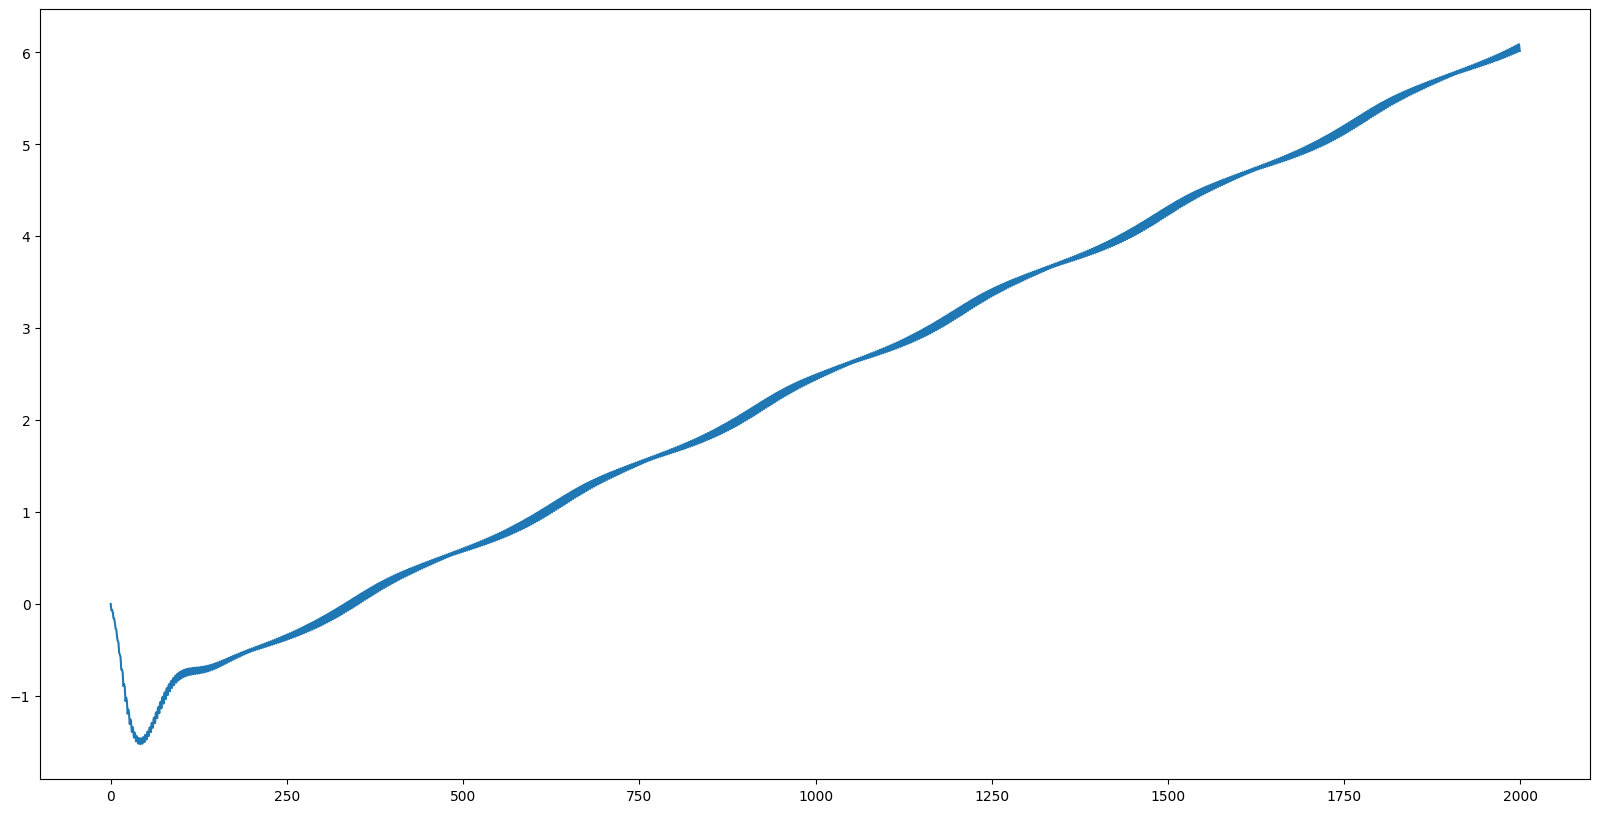

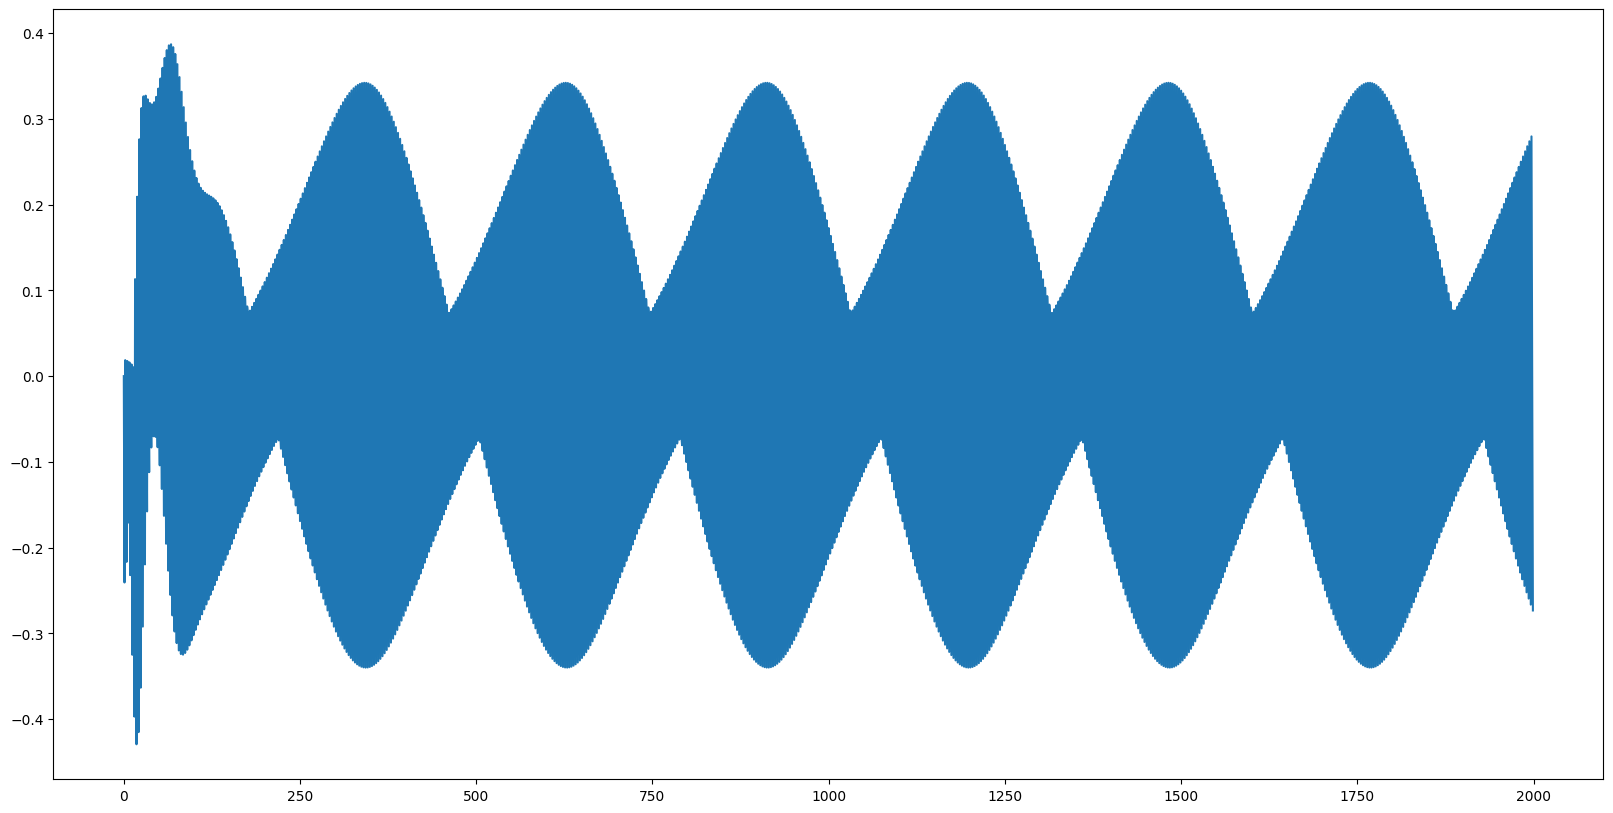

In [20]:
start, width = 0, 2000

plot_signals([phases], start=start, width=width, normalize=False)
plot_signals([errors], start=start, width=width, normalize=False)

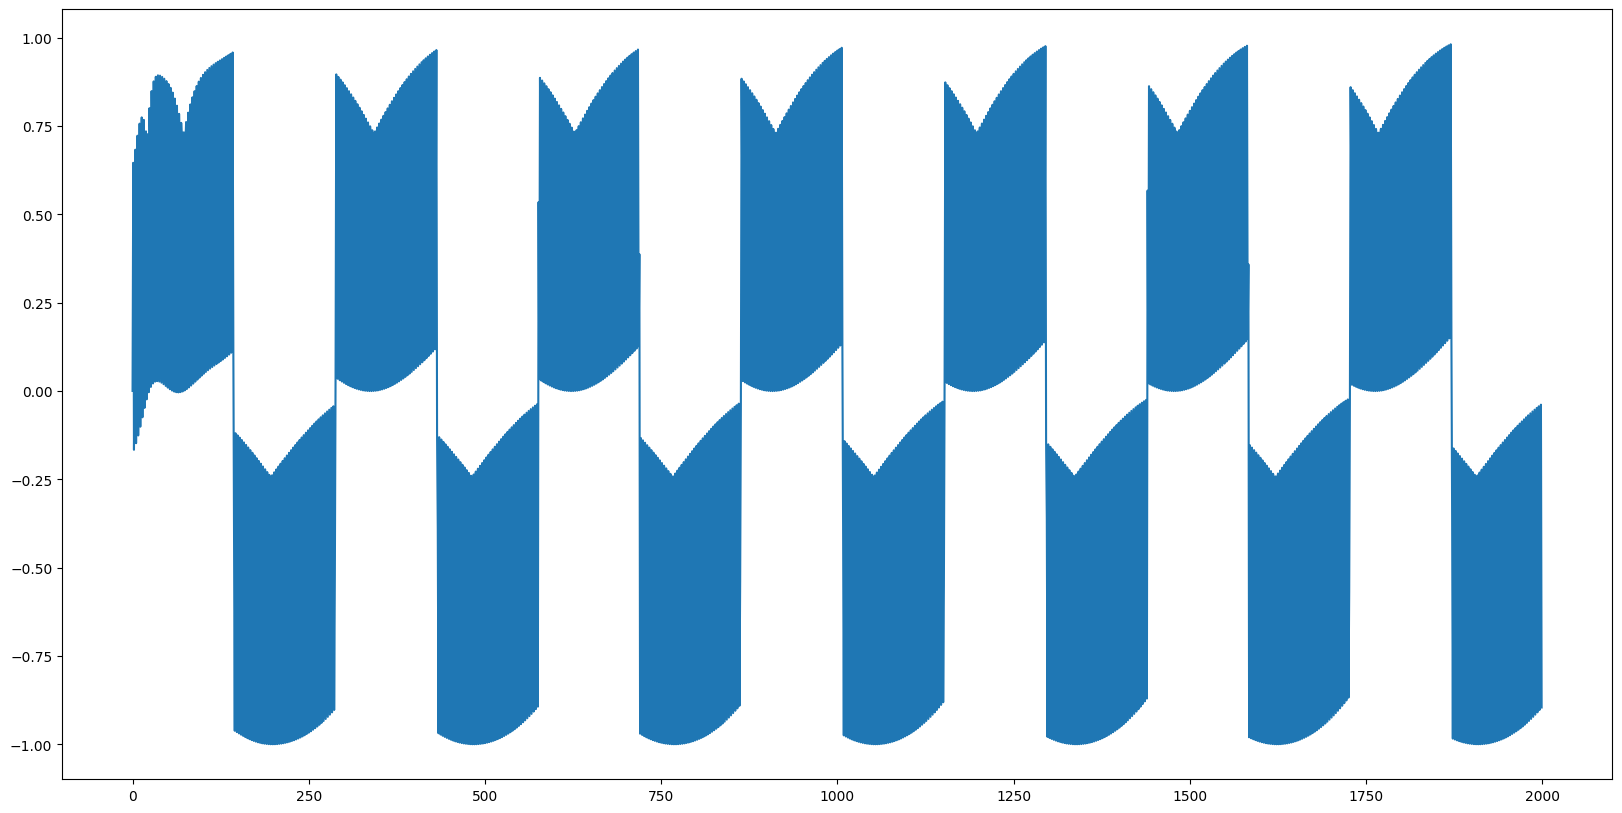

In [21]:
plot_signals([msg], start=start, width=width, normalize=False)

Very promising. Additional lowpass filtering should leave only the message signal and remove doubled carrier frequency (114kHz).

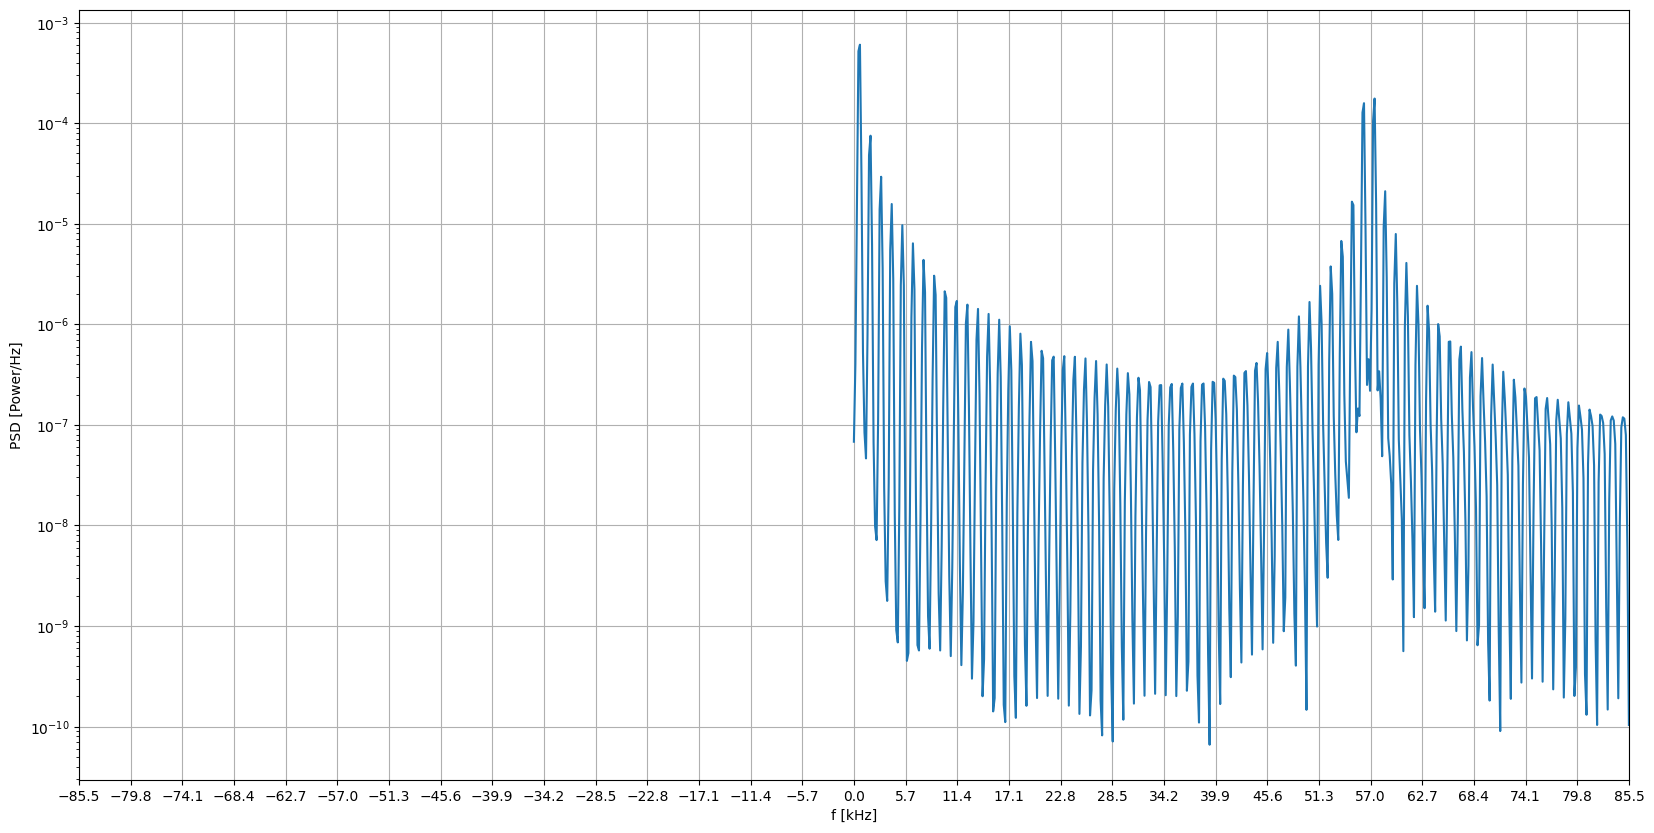

In [22]:
from utils import welch
welch(msg, rds_sample_rate)

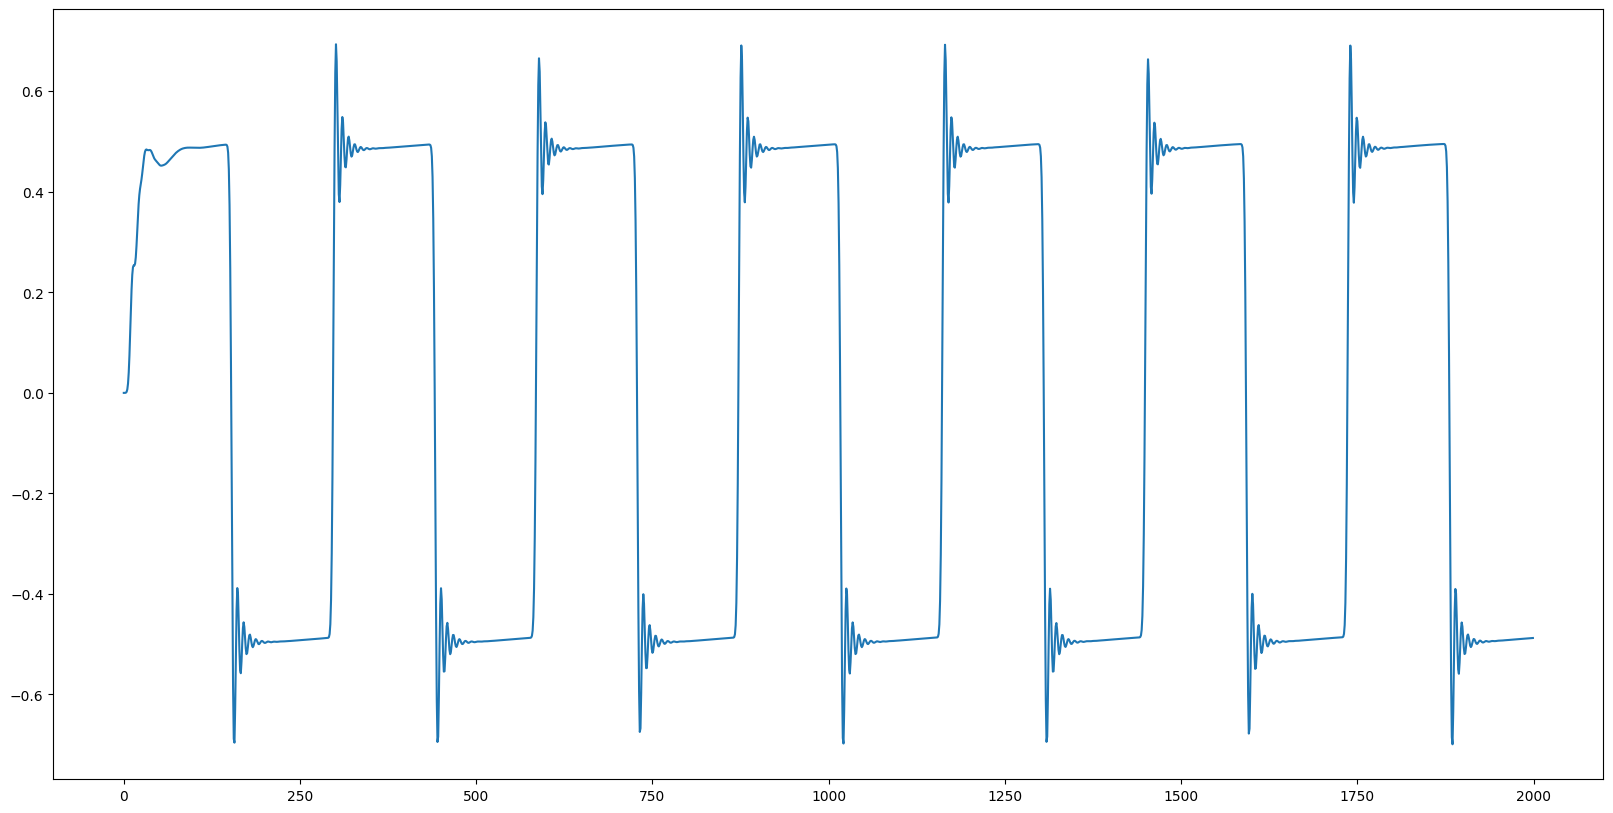

In [23]:
from utils import lowpass
msg_lp = lowpass(msg, rds_sample_rate, 20000)
plot_signals([msg_lp], start=start, width=width, normalize=False)

Perfection.

# Costas loop on pulse-shaped signal

In [24]:
def rrc_impulse_response(ts, beta, T_s):
    def rrc(t):
        if t == 0:
            return (1 + beta * (4 / np.pi - 1)) / T_s
        elif np.abs(t) == (T_s / (4 * beta)):
            # will we ever hit it? (precision)
            return (beta * ((1 + 2 / np.pi) * np.sin(np.pi / (4 * beta)) + (1 - 2 / np.pi) *np.cos(np.pi / (4 * beta)))) / (T_s * np.sqrt(2))
        else:
            num = np.sin(np.pi * t / T_s * (1 - beta)) + 4 * beta * t  / T_s * np.cos(np.pi * t / T_s * (1 + beta))
            denom = np.pi * t * (1 - (4 * beta * t / T_s) ** 2)
            return num / denom
    
    return np.array([rrc(t) for t in ts])

symbol_rate = rds_sample_rate / samples_per_symbol
T_s = 1 / symbol_rate
ts = np.arange(-50 * 32 / sample_rate, (50 * 32 + 1) / rds_sample_rate, 1 / rds_sample_rate)
ps_filter = rrc_impulse_response(ts, beta=0.35, T_s=T_s) * T_s

In [25]:
bpsk_data = np.ones(int(len(t_s) / samples_per_symbol) + 1)
bpsk_data[::2] *= -1
bpsk_pulse_train = np.zeros(len(t_s))
bpsk_pulse_train[::int(samples_per_symbol)] = bpsk_data
    
bpsk_data_ps = np.convolve(bpsk_pulse_train, ps_filter, mode='same')
bpsk_mod_signal_ps = bpsk_data_ps * carrier

~600Hz sinusoid is produced

In [26]:
1 / (2 * samples_per_symbol / rds_sample_rate)

593.75

In [27]:
phases, errors, msg = costas_loop(bpsk_mod_signal_ps, rds_sample_rate, f_rds, c_k_p, c_k_i, 1)

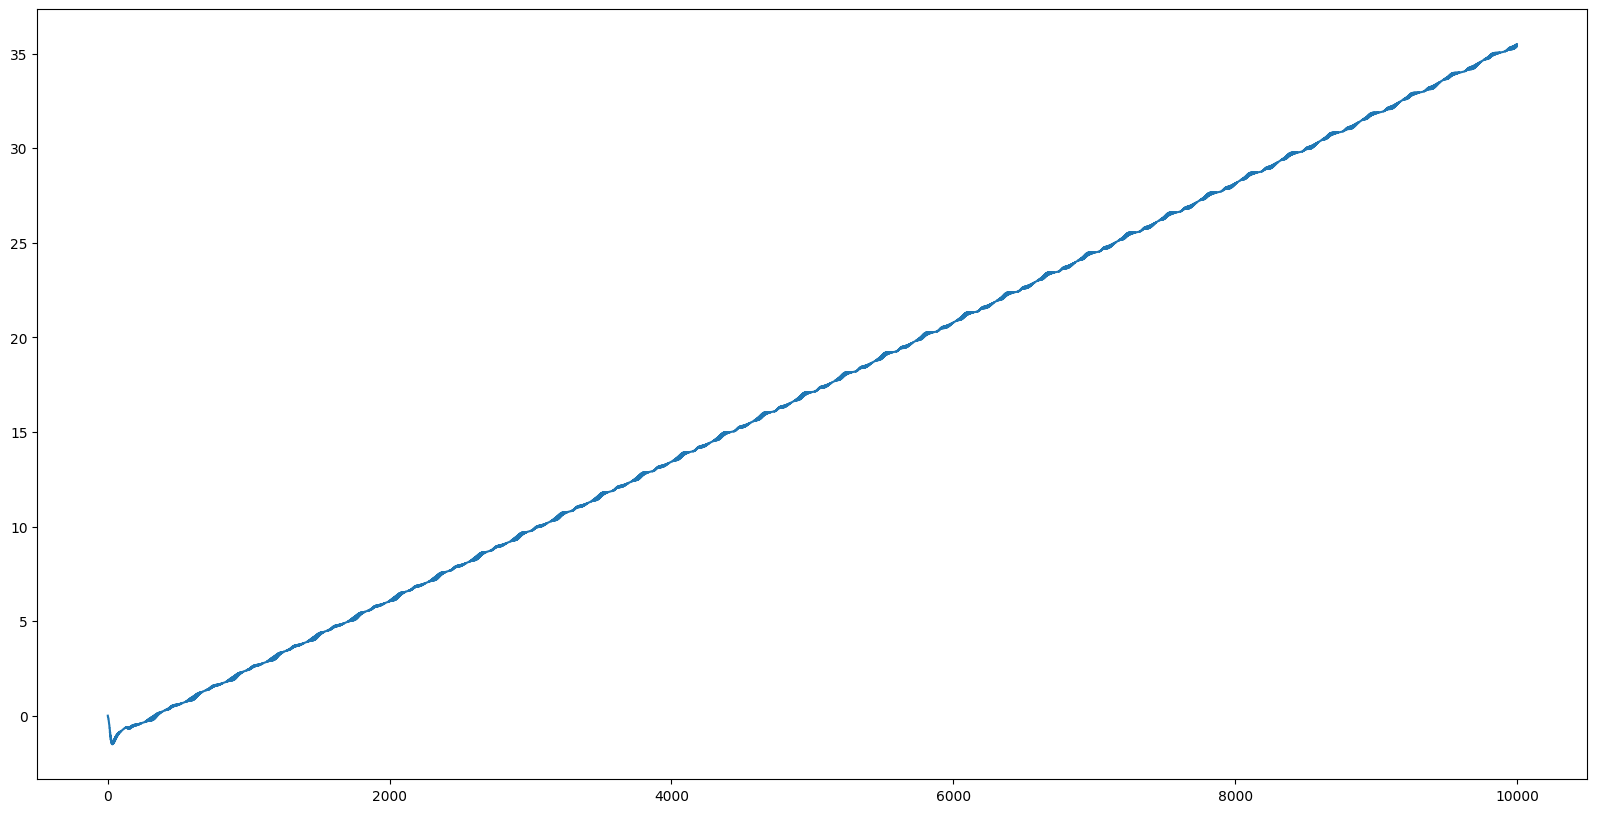

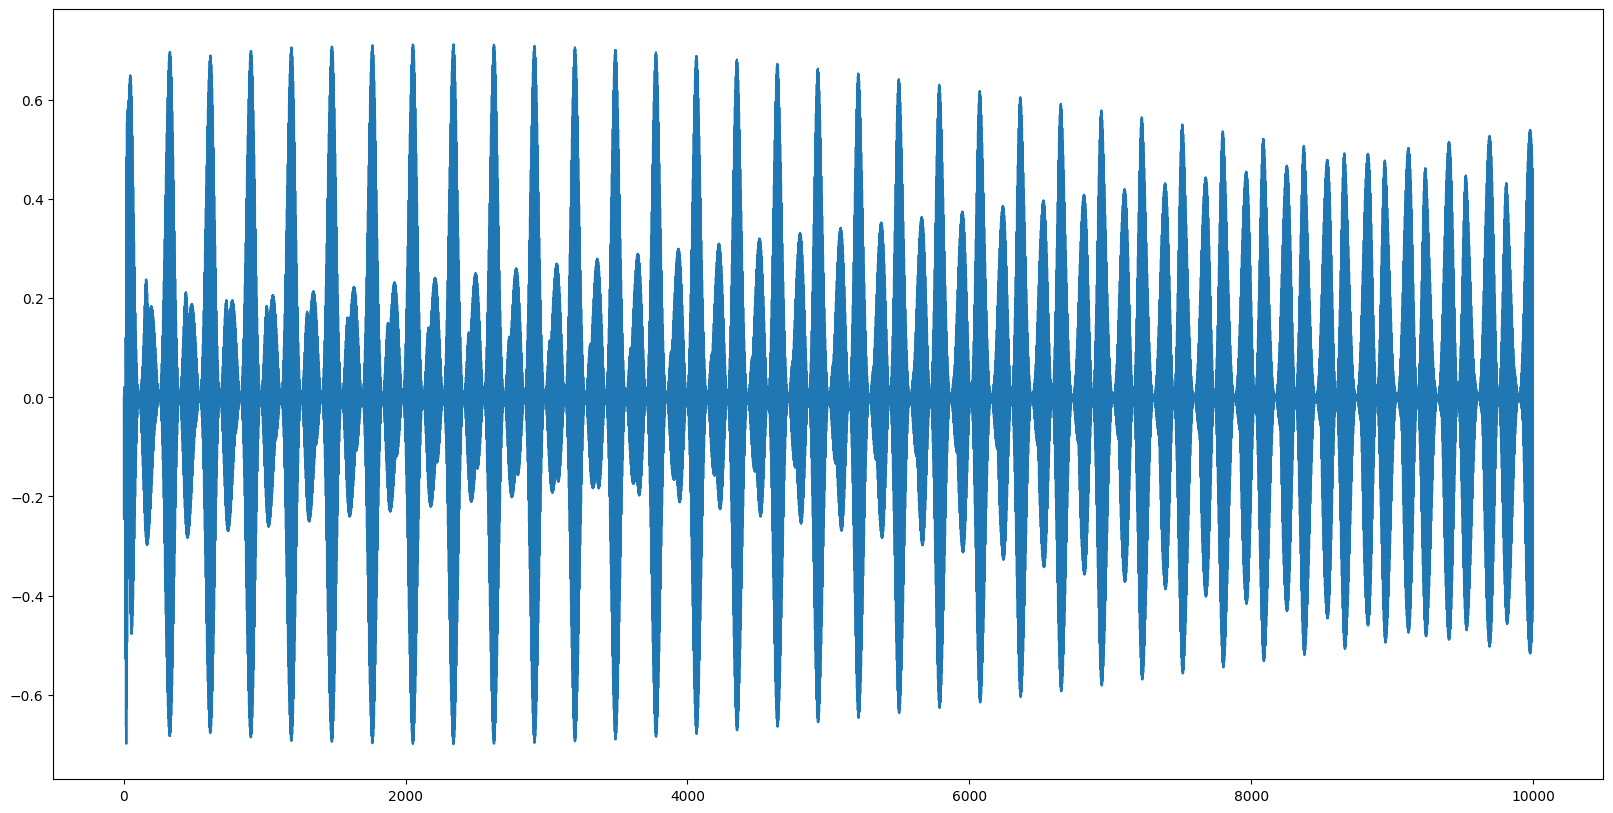

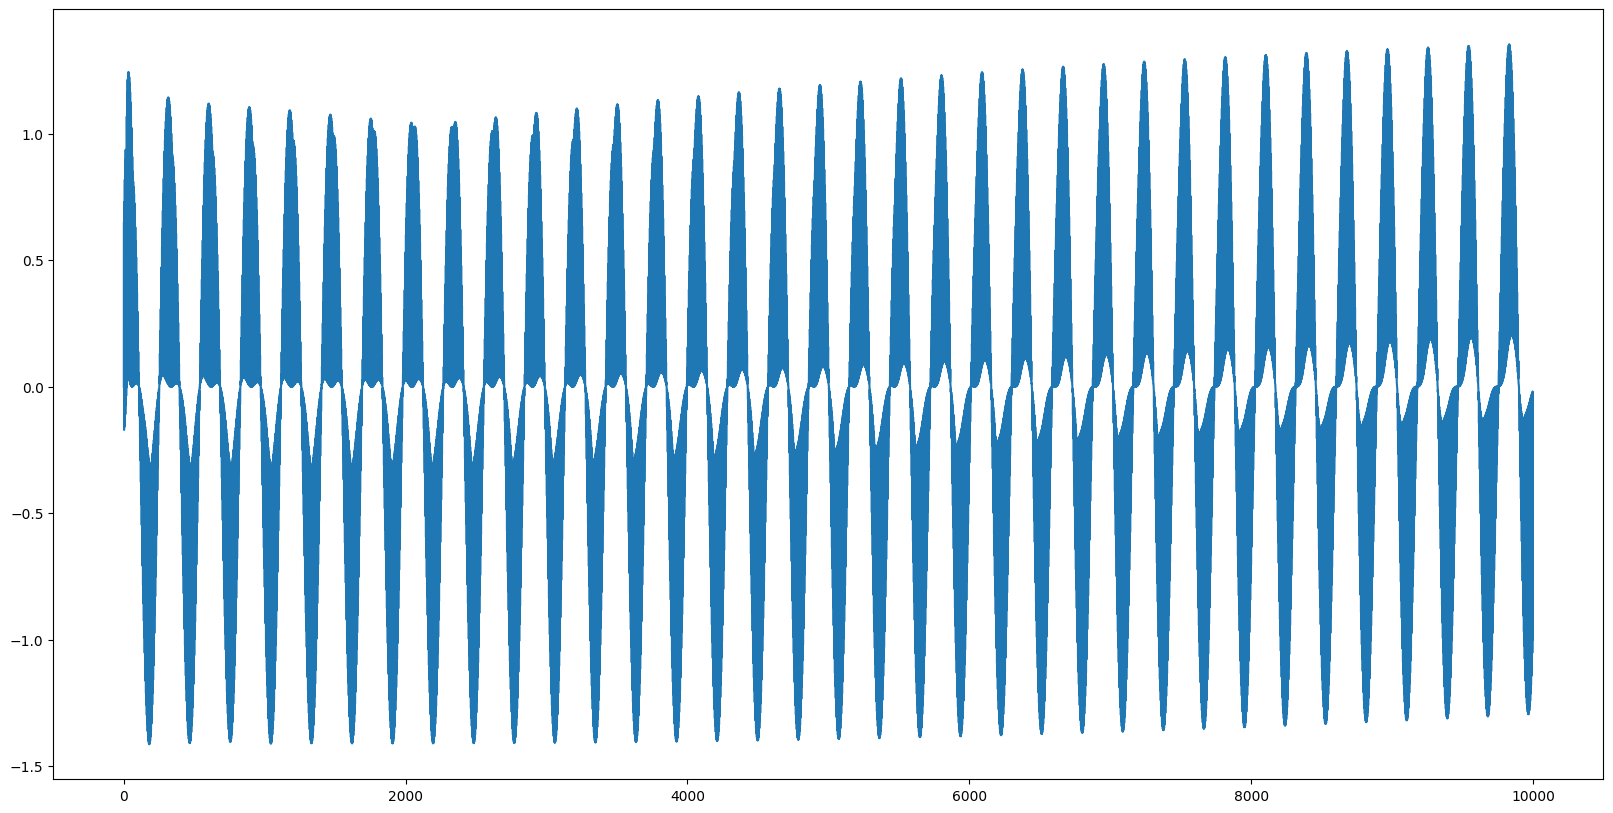

In [28]:
start, width = 0, 10000
plot_signals([phases], start=start, width=width, normalize=False)
plot_signals([errors], start=start, width=width, normalize=False)
plot_signals([msg], start=start, width=width, normalize=False)

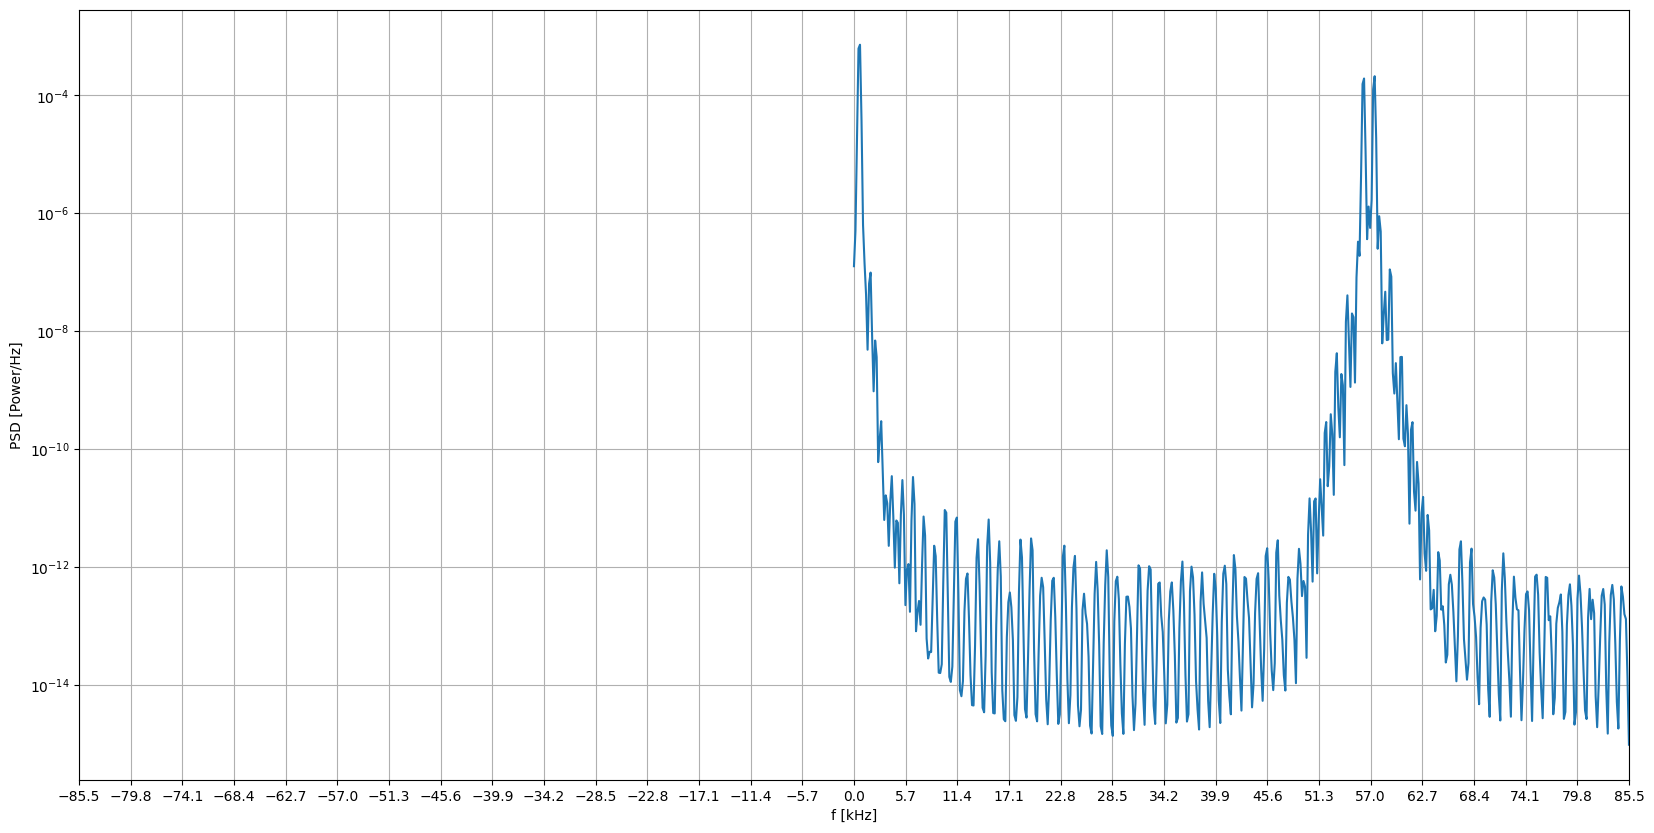

In [29]:
welch(msg, rds_sample_rate)

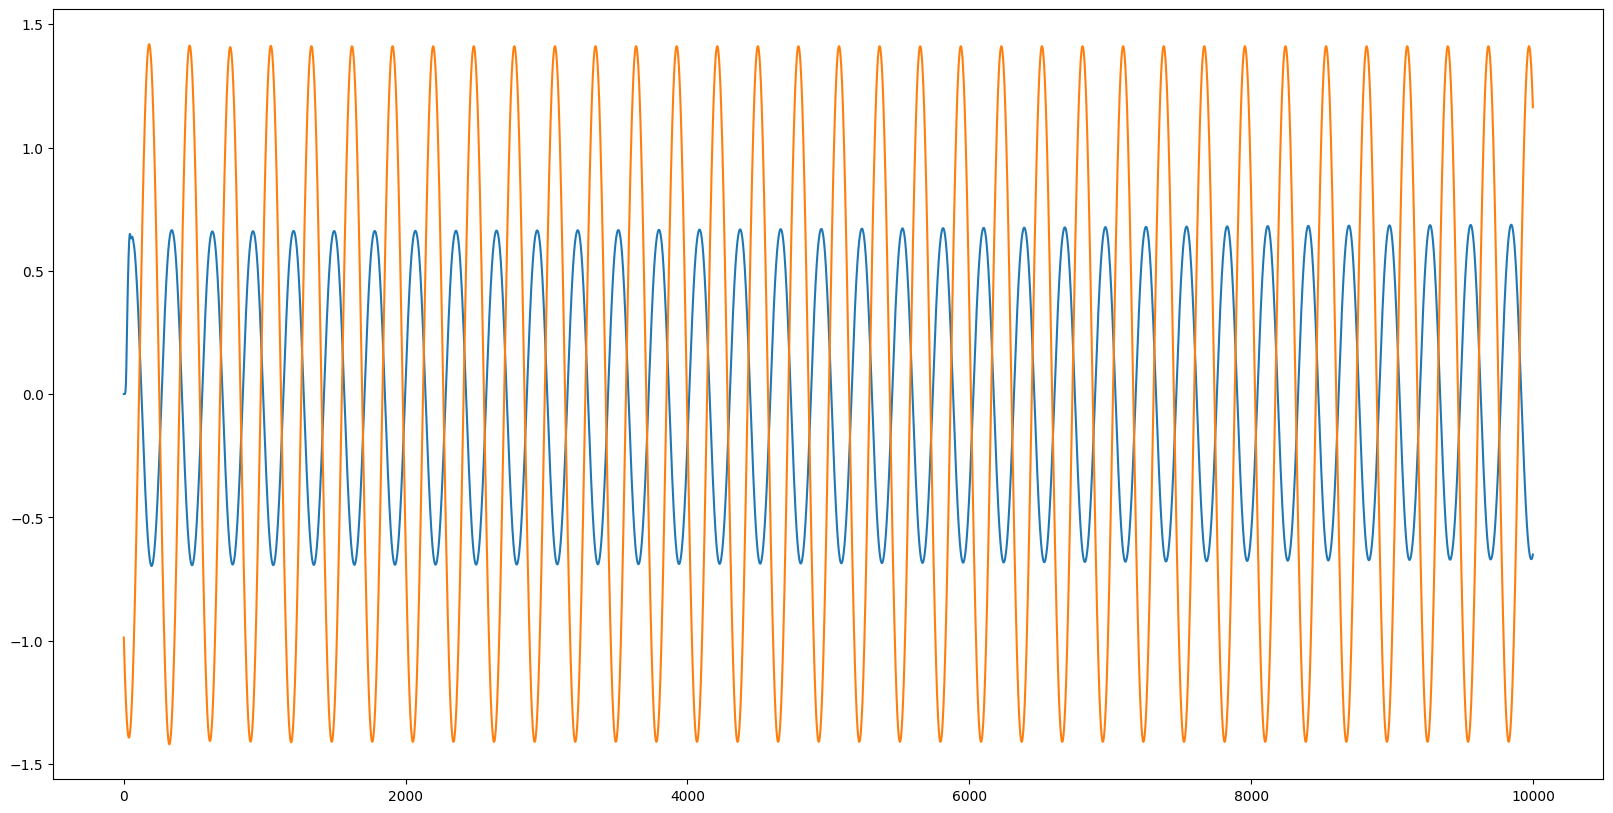

In [30]:
msg = lowpass(msg, rds_sample_rate, 10000)
plot_signals([msg, bpsk_data_ps], start=start, width=width, normalize=False)

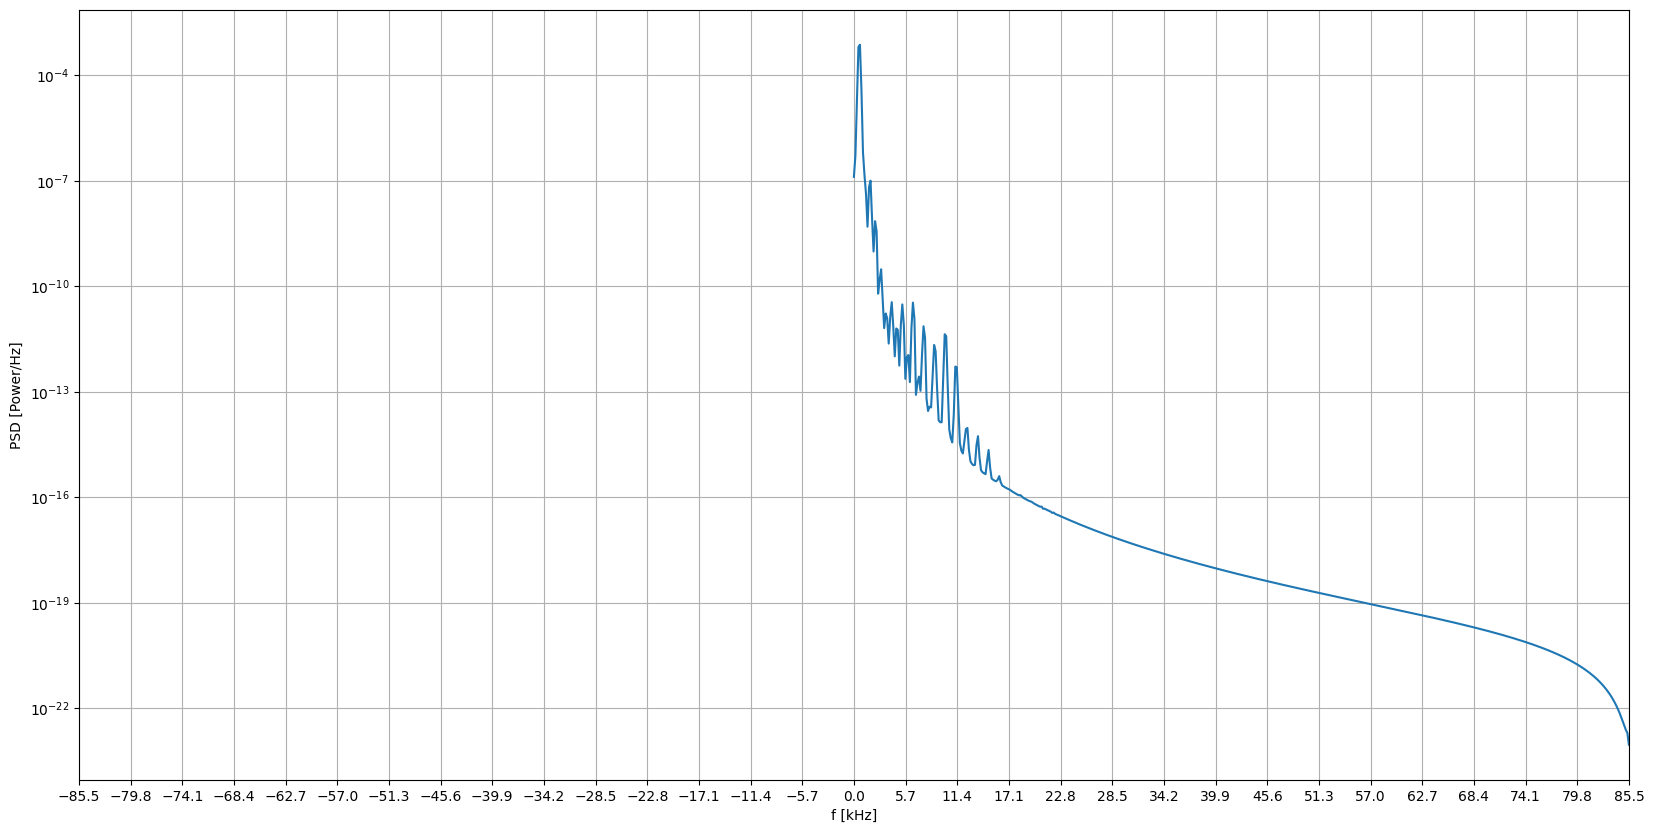

In [31]:
welch(msg, rds_sample_rate)

# Costas loop with lowpass filtered I and Q branches
That's what's always shown in schematics and what makes sense, but PySDR completely ignores branch filters and only leaves loop filter (like `costas_loop` above). It's interesting if these change anything about the loop behavior, e.g. do loop filter coefficients still work? [2] seems to ignore these filters when deriving transfer function.

In [32]:
import scipy 


def costas_loop_lowpass(input_signal, sample_rate, f_0, k_p, k_i, nco_gain):
    phases, errors, msg = np.zeros(len(input_signal)), [], []
    integrator_acc, phase = 0, 0

    cutoff = 10000 / (sample_rate * 0.5)    
    b, a = scipy.signal.butter(10, cutoff, btype='low', analog=False)
    y_s, x_s = np.zeros(len(a) - 1), np.zeros(len(b))
    
    def apply_iir_filter(sample):
        nonlocal y_s, x_s
        x_s = np.roll(x_s, 1)
        x_s[0] = sample
        y_n = (np.dot(b, x_s) - np.dot(a[1:], y_s)) / a[0]
        y_s = np.roll(y_s, 1)
        y_s[0] = y_n
        return y_n

    c = np.flip(scipy.signal.firwin(64, cutoff))
    x_s_fir = np.zeros(len(c))
    
    def apply_fir_filter(sample):
        nonlocal x_s_fir
        x_s_fir = np.roll(x_s_fir, 1)
        x_s_fir[0] = sample
        return np.dot(c, x_s_fir)
    
    for i, sample in enumerate(input_signal):
        sin_res = apply_fir_filter(np.sin(2 * np.pi * f_0 * i / sample_rate + phase) * sample)
        cos_res = apply_fir_filter(np.cos(2 * np.pi * f_0 * i / sample_rate + phase) * sample)
        error = sin_res * cos_res

        integrator_acc += k_i * error
        phase += nco_gain * (integrator_acc + k_p * error)

        phases[i] = phase
        errors.append(error)
        msg.append(sin_res)

    return phases, errors, msg

In [33]:
phases, errors, msg = costas_loop_lowpass(bpsk_mod_signal, rds_sample_rate, f_rds, c_k_p, c_k_i, 1)

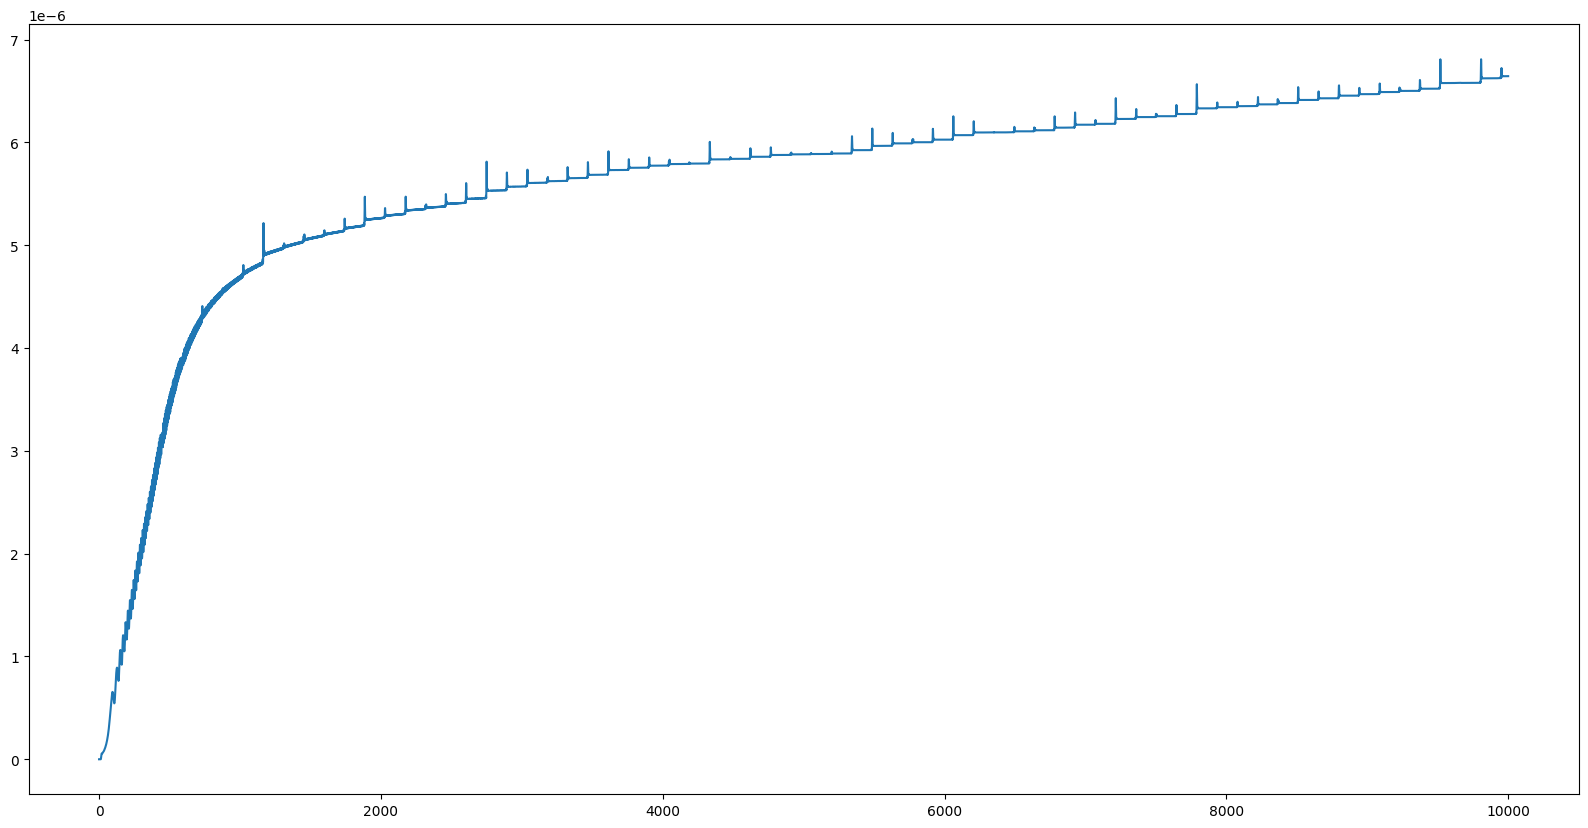

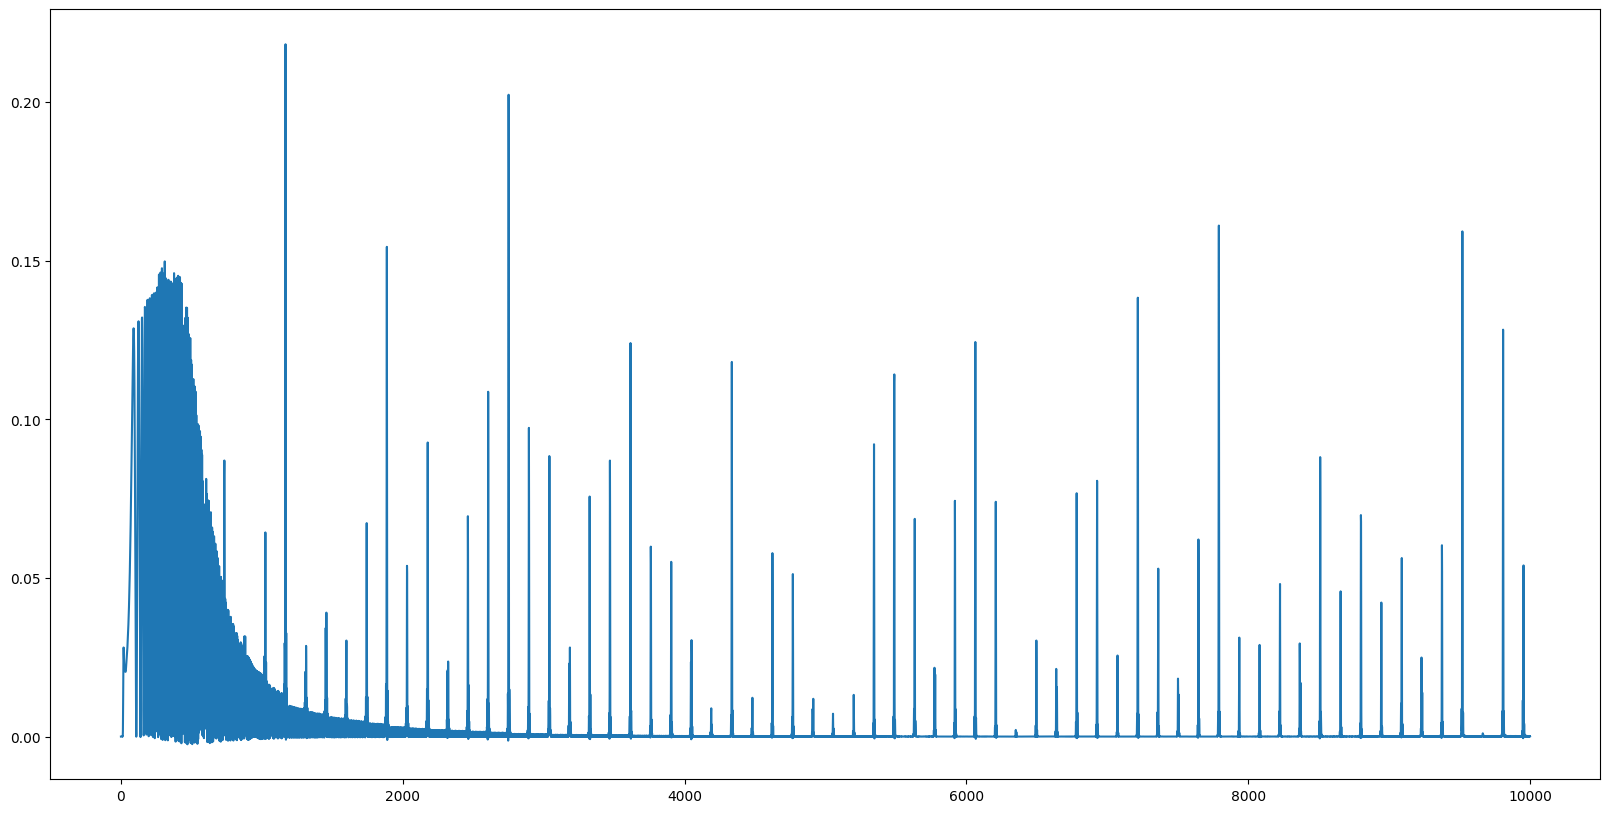

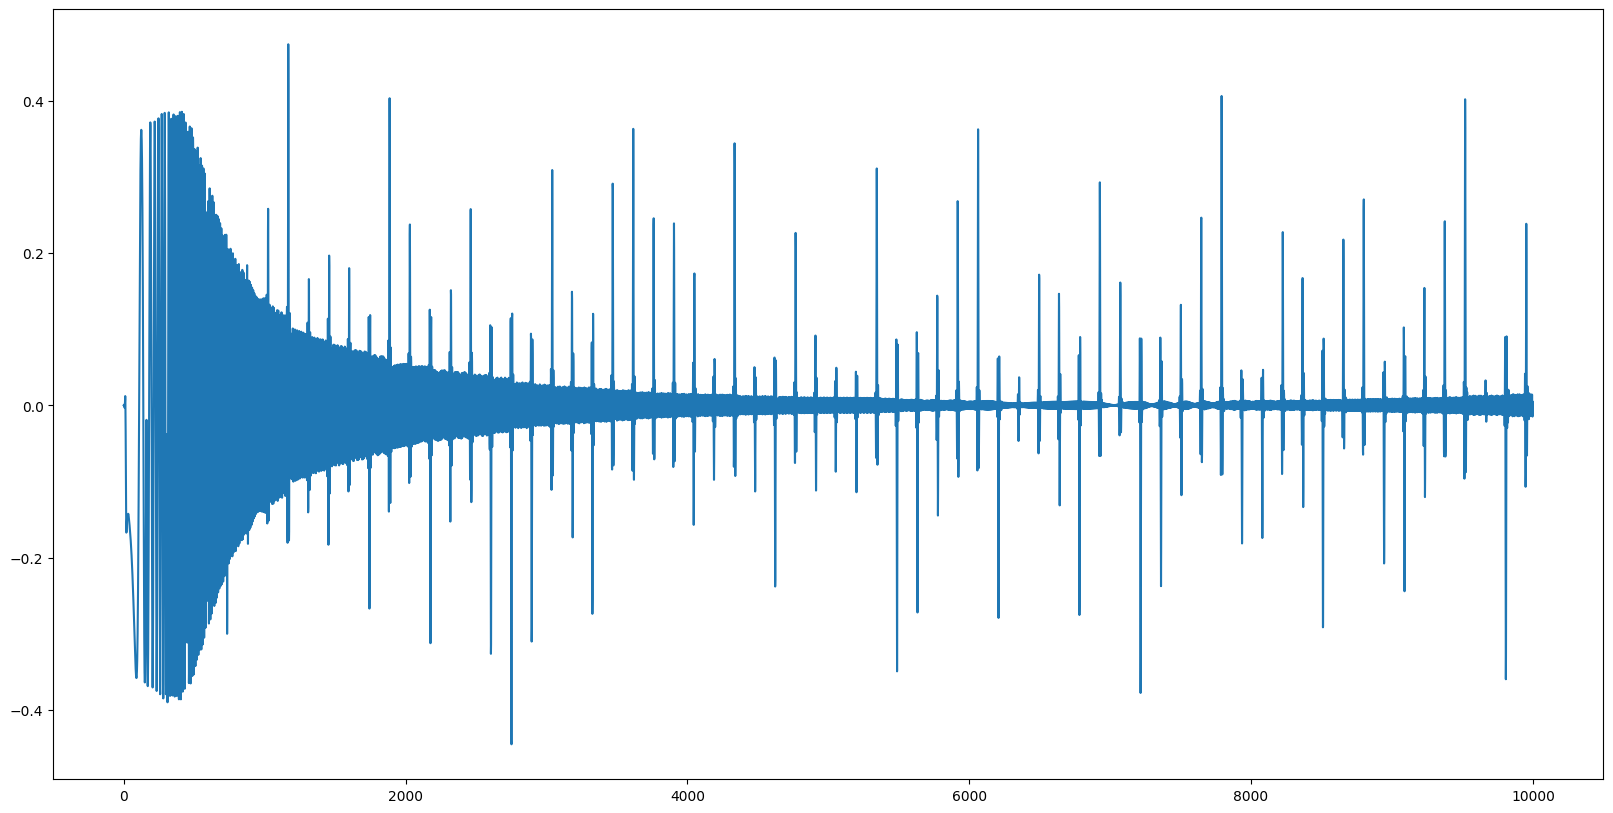

In [34]:
width = 10000
plot_signals([(phases[1:] - phases[:-1]) / rds_sample_rate], start=start, width=width, normalize=False)
plot_signals([errors], start=start, width=width, normalize=False)
plot_signals([msg], start=start, width=width, normalize=False)

Well... It doesn't lock anymore. Tried both IIR and FIR, no idea how the type of used filter affects behavior. Do we need to derive transfer functions anew for this kind of implementation? Maybe.

Out of the blue, let's give up on the PI loop filter and go FIR everywhere.

In [35]:
def costas_loop_fir_lowpass(input_signal, sample_rate, f_0, nco_gain):
    phases, errors, msg = np.zeros(len(input_signal)), [], []
    phase = 0

    class FilterWrapper:
        def __init__(self, coef):
            self.coef = coef
            self.samples = np.zeros(len(coef))
            
        def __call__(self, sample):
            self.samples = np.roll(self.samples, 1)
            self.samples[0] = sample
            return np.dot(self.coef, self.samples)

    arm_cutoff = 2400 / (sample_rate * 0.5)
    arm_filter_coef = np.flip(scipy.signal.firwin(8, arm_cutoff))
    sin_filter = FilterWrapper(arm_filter_coef)
    cos_filter = FilterWrapper(arm_filter_coef)

    lf_cutoff = 5000 / (sample_rate * 0.5)
    loop_filter = FilterWrapper(np.flip(scipy.signal.firwin(8, lf_cutoff)))
    
    for i, sample in enumerate(input_signal):
        sin_res = sin_filter(np.sin(2 * np.pi * f_0 * i / sample_rate + phase) * sample)
        cos_res = cos_filter(np.cos(2 * np.pi * f_0 * i / sample_rate + phase) * sample)
        error = sin_res * cos_res

        phase += 0.01 * loop_filter(error)
        
        phases[i] = phase
        errors.append(error)
        msg.append(sin_res)

    return phases, errors, msg

In [36]:
phases, errors, msg = costas_loop_fir_lowpass(bpsk_mod_signal, rds_sample_rate, f_rds, 1)

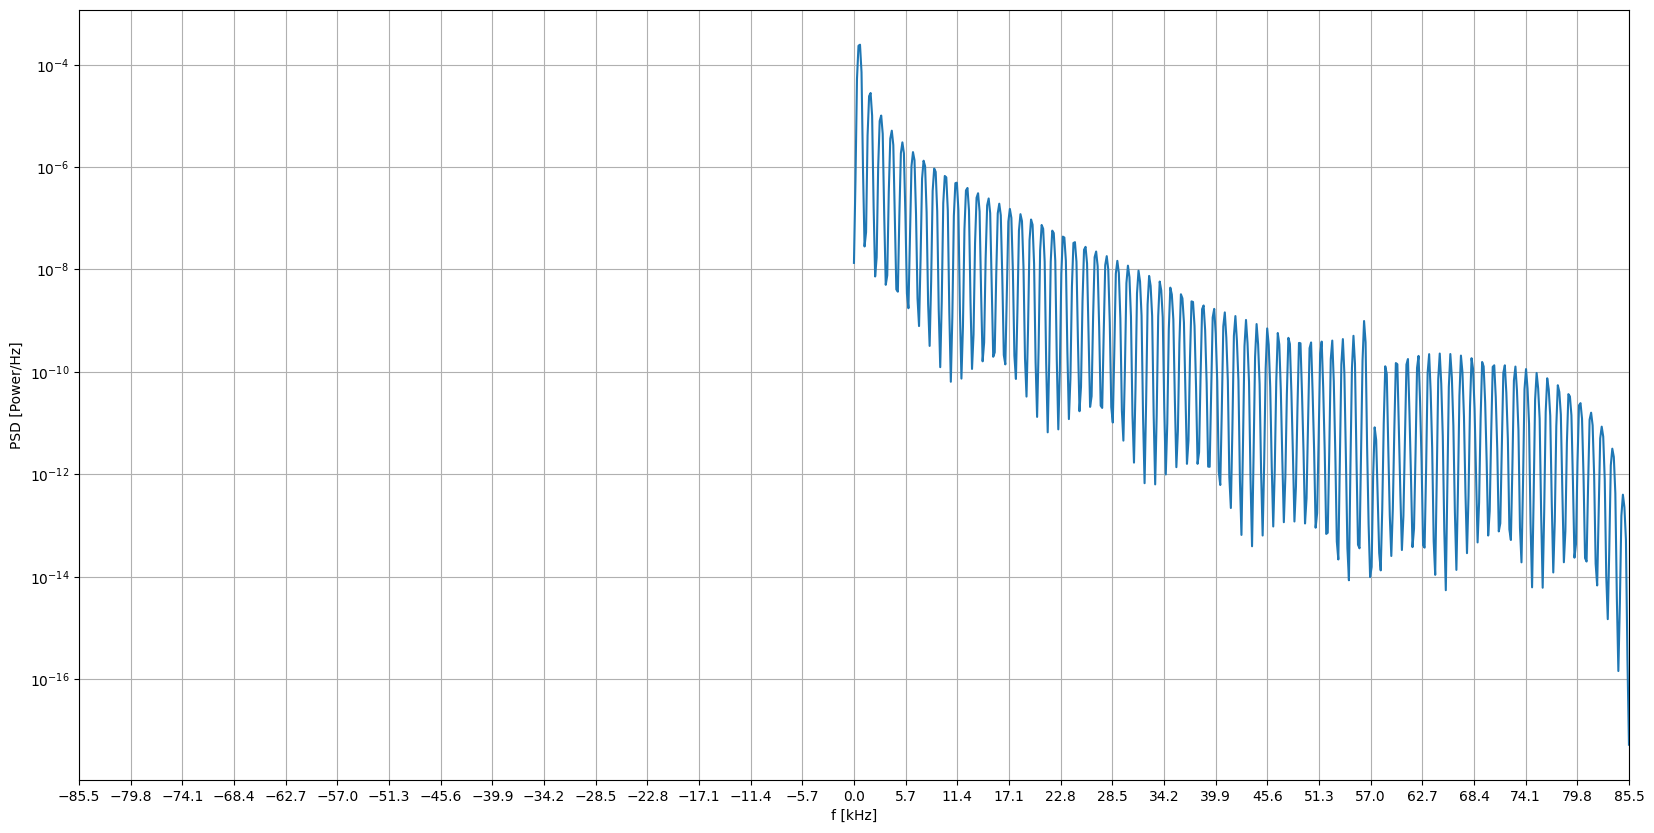

In [37]:
welch(msg, rds_sample_rate)

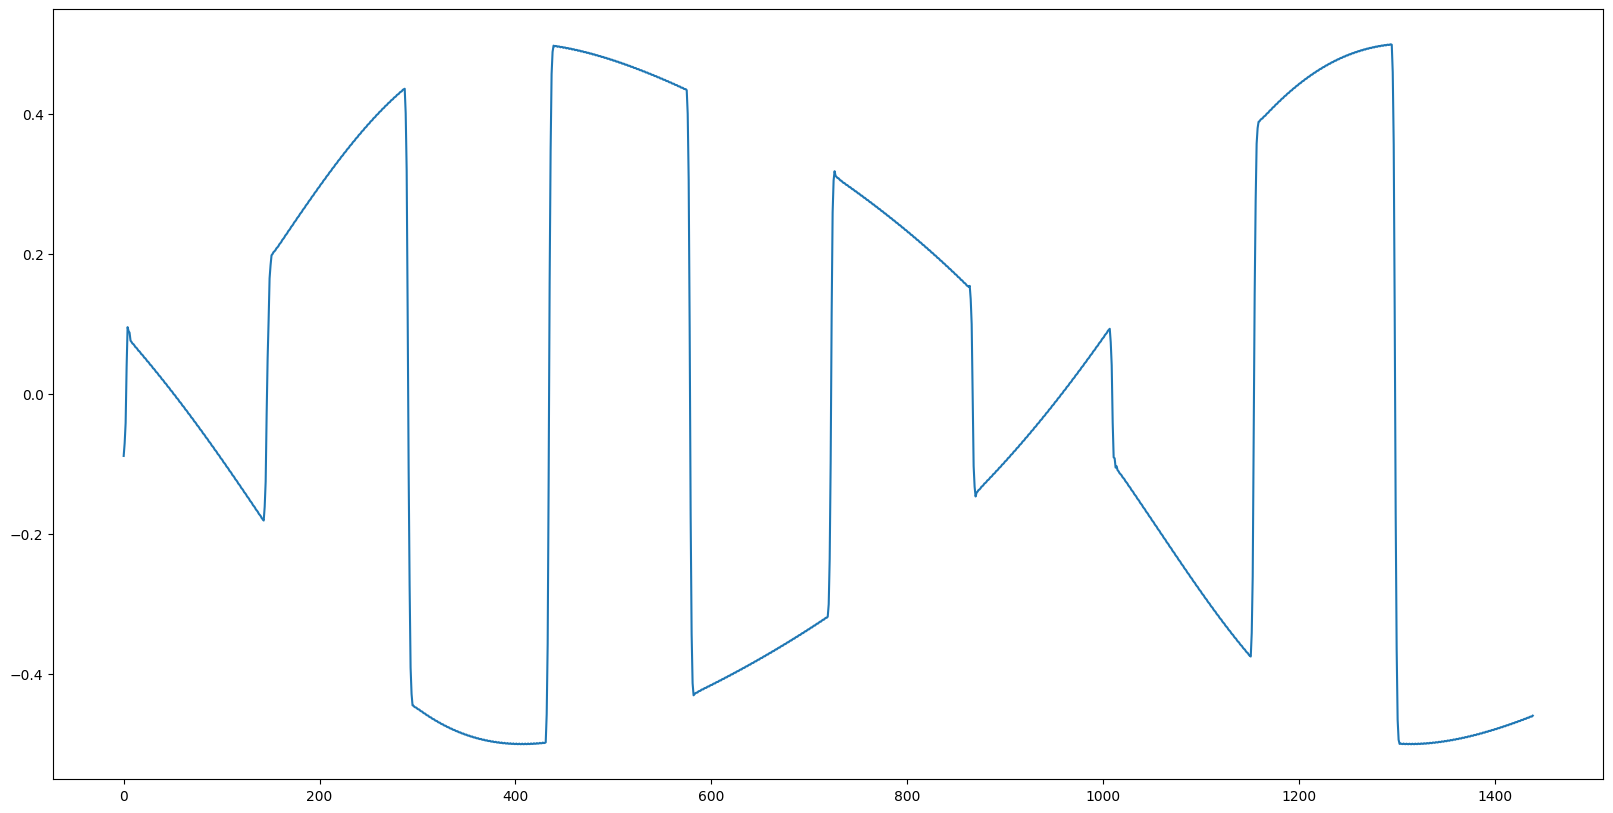

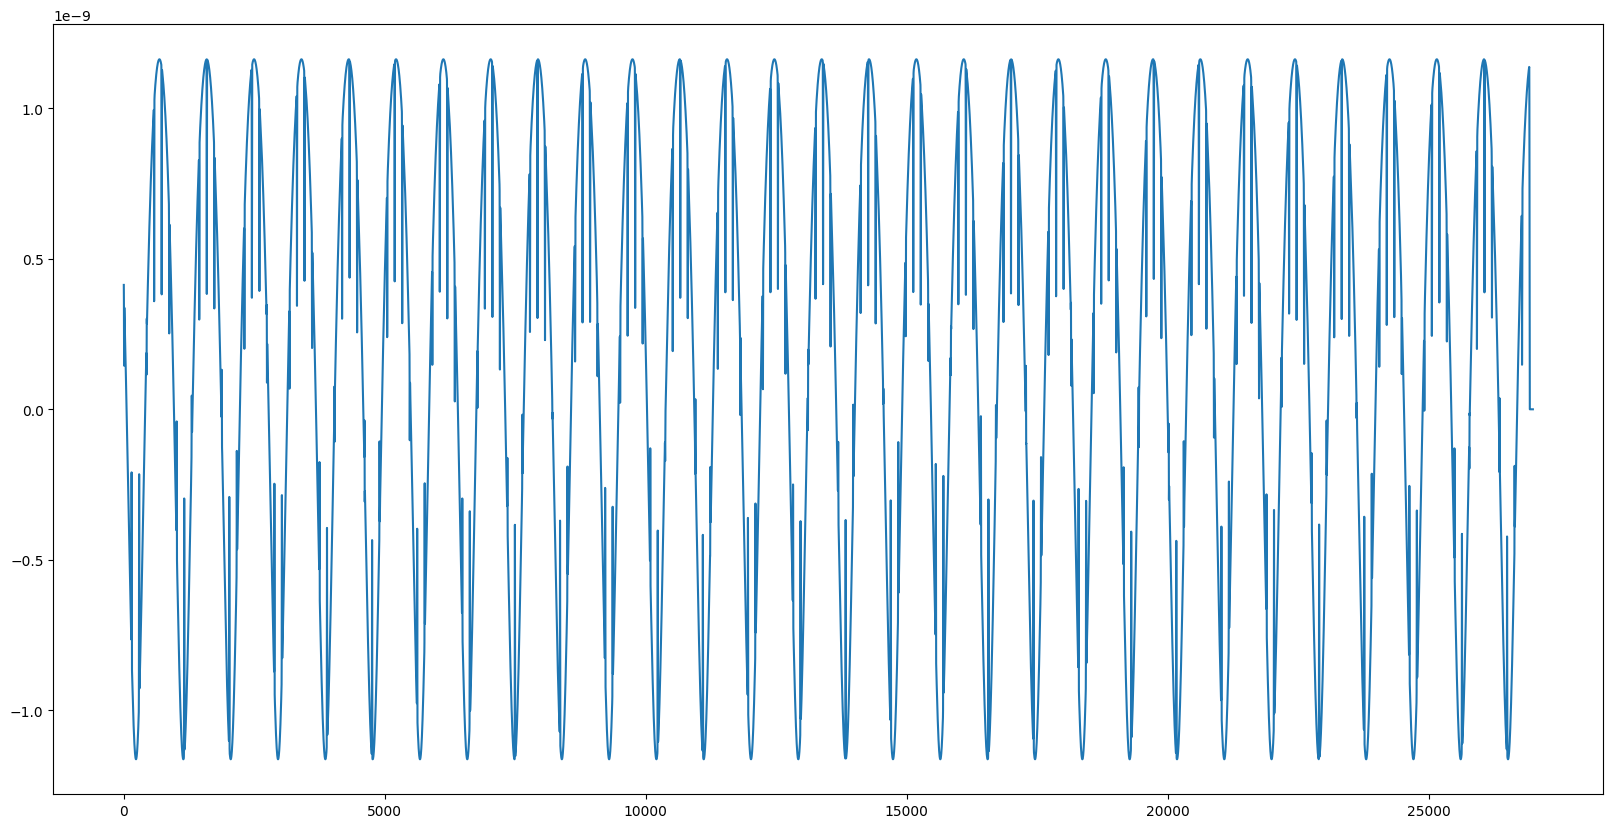

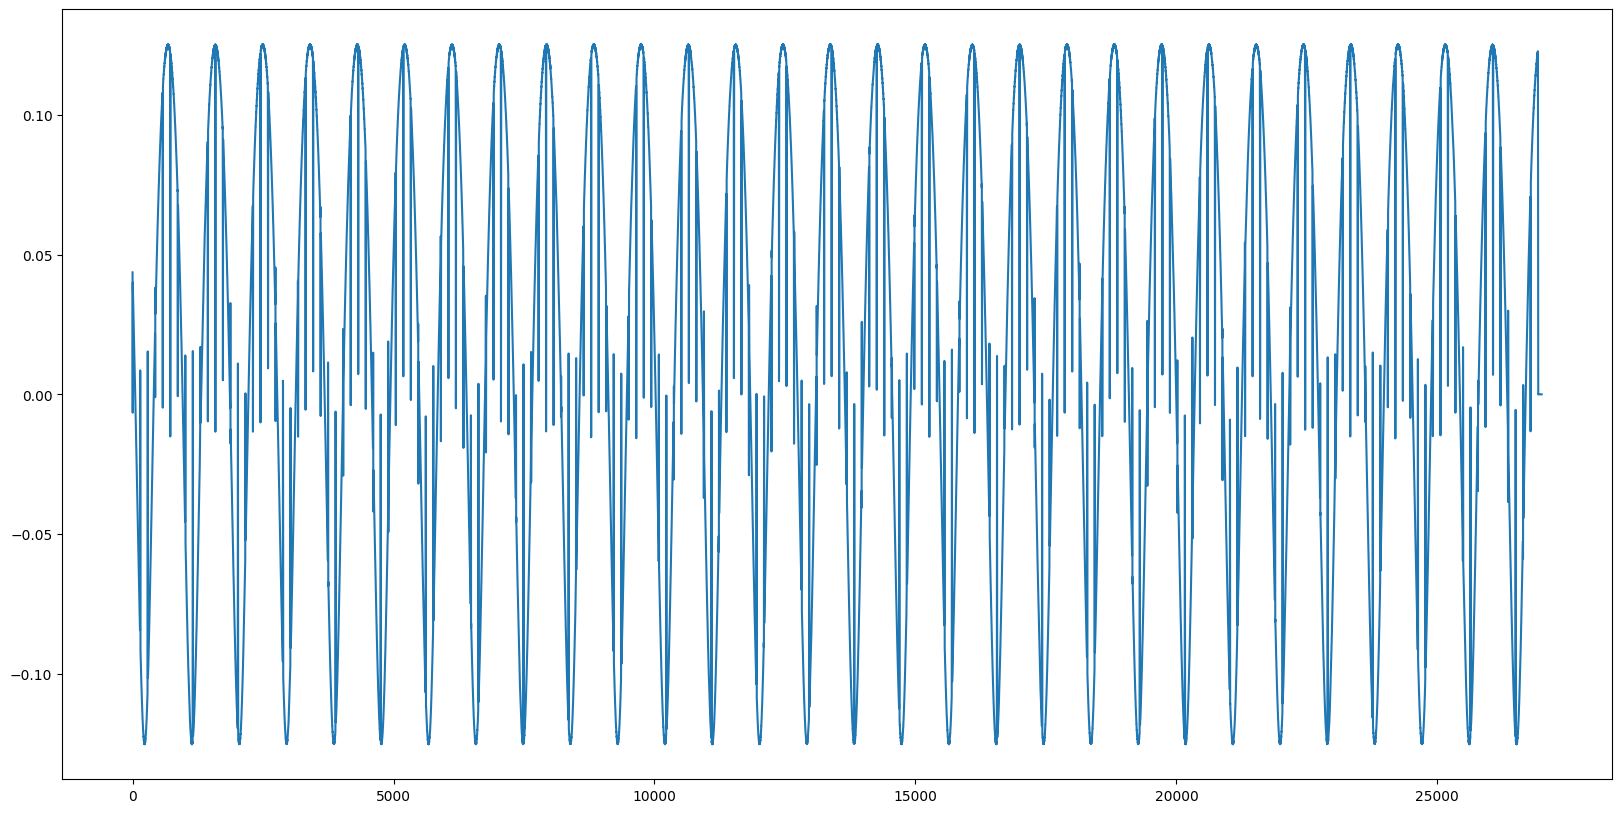

In [38]:
start, width = 1000 * int(samples_per_symbol), 10 * int(samples_per_symbol)
plot_signals([msg], start=start, width=width, normalize=False)
plot_signals([(phases[1:] - phases[:-1]) / (2 * np.pi * rds_sample_rate)], start=start, normalize=False)
plot_signals([errors], start=start, normalize=False)